In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, len(nearest_indexes) - 1)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes)
    return column

def cubic_spline_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                cubic_spline = CubicSpline(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = cubic_spline(x)
                plot_polynomial(cubic_spline, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Polynomial Plot')

    plt.show()

In [4]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_columns = 0, skiped_rows = 0):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)       
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_filler(df[col])
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

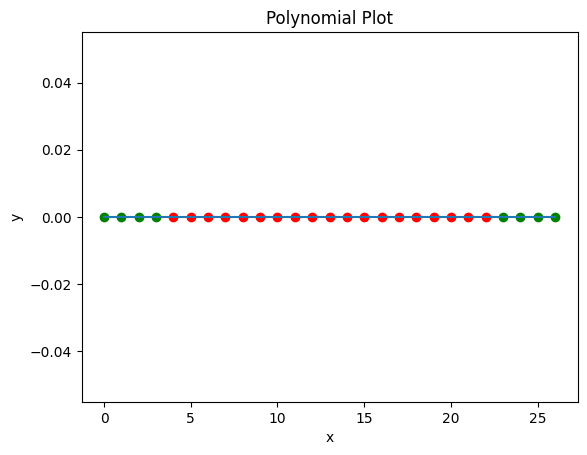

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1992,9.216314,8.980849,11.55573,5.92294,8.211435,5.710858,8.416935,7.296177,6.66365,3.358037,...,6.054656,7.165673,8.196342,7.431412,6.698602,5.154645,4.260728,7.43793,8.810622,6.100175
1993,10.05649,11.086582,16.032611,8.304413,7.681225,5.335375,9.475439,6.077933,5.822818,3.607978,...,5.375051,8.010937,7.681198,7.250549,5.913455,4.851567,3.348243,9.922345,7.827288,5.300097
1995,9.80071,8.312264,11.311703,13.067481,7.45973,5.735904,8.233751,5.015059,7.133533,3.317694,...,6.364125,7.511759,7.31991,7.659531,13.727837,5.933302,3.642741,7.636,8.02107,7.599651
1996,8.437029,8.011287,10.816192,7.528157,8.524951,5.994351,12.910183,6.764575,8.095008,3.57012,...,6.104889,8.593678,6.496756,5.625785,13.094003,6.850794,4.44975,9.298501,9.054236,6.020697
1997,8.887605,7.972121,15.131507,10.932264,8.366323,7.107643,10.255129,6.932531,7.258219,4.542337,...,7.451048,9.408432,10.088293,6.551033,3.705357,7.995407,4.993038,7.306369,10.557259,8.674082
1998,8.53551,12.287512,18.481736,10.538872,8.734137,7.257648,12.260437,7.363315,8.600943,4.45229,...,8.429585,10.949554,8.109205,6.542544,7.510324,8.633985,7.590661,11.415608,12.761422,6.550195
1999,12.203437,14.748984,19.326194,15.278558,9.92229,7.35609,15.22804,8.801633,9.487636,5.013055,...,9.938677,11.482436,10.267647,9.425285,7.497685,8.444023,8.12387,10.196662,12.920109,6.078458
2001,8.558123,12.065698,10.684138,19.057839,10.603811,7.983141,14.697847,10.093378,8.508379,7.897115,...,8.476753,12.460144,9.064111,9.02379,8.860495,7.627902,4.49397,12.743467,11.451631,6.955401
2002,6.582788,9.080515,12.966133,20.539464,10.735432,8.857219,14.215385,10.666093,6.903738,5.929567,...,7.704473,11.712196,7.255709,6.878789,5.89899,7.708314,4.990287,10.988206,11.819351,8.634615


In [5]:
df_2014 = read_csv_replace_missing_by_polynomial('desemprego_ipeadata.csv', 2, 1)
df_2014 = df_2014.iloc[:, 2:-1]
df_2014 = df_2014.T
header = df_2014.iloc[0]
df_2014 = df_2014[1:]
df_2014.columns = header
df_2014 = df_2014.rename_axis('Ano')
df_2014

In [6]:
df = pd.read_csv('desemprego_pos_2012.csv')

df_transposed = df.transpose()
df_transposed
new_header = df_transposed.iloc[0]
df_transposed = df_transposed[1:]
df_transposed.columns = new_header
df_transposed = df_transposed.rename_axis('Ano')
df_transposed

Estado,Acre,Rondônia,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,...,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
Ano,,,,,,,,,,,,,,,,,,,,,
2012,9.2,8.1,11.1,8.5,8.0,12.6,8.4,7.9,7.7,7.3,...,7.6,8.6,7.8,5.6,4.1,5.3,7.6,6.6,6.3,8.8
2012.1,9.0,6.3,9.1,5.9,7.9,14.7,7.8,9.2,7.1,8.2,...,7.3,7.5,7.5,5.3,3.8,5.1,7.1,5.8,5.3,8.5
2012.2,7.8,5.9,9.5,7.5,7.2,14.2,7.3,7.7,6.2,8.1,...,6.9,7.5,7.0,4.7,3.2,4.7,5.0,5.2,5.0,8.7
2012.3,8.2,5.2,8.3,8.4,6.9,12.1,7.7,7.6,7.0,7.6,...,6.7,6.9,6.8,4.5,2.7,4.4,5.0,4.8,5.1,8.9
2013,10.9,6.2,10.4,8.9,7.9,11.5,9.3,9.5,8.4,8.9,...,7.8,7.3,7.8,4.9,3.7,5.4,4.8,5.8,6.8,9.7
2013.1,9.6,4.9,10.3,8.6,7.7,14.5,8.3,9.4,7.5,8.5,...,7.7,7.0,7.5,4.6,3.5,4.6,5.0,4.5,5.8,9.2
2013.2,8.9,4.6,8.4,8.0,7.8,11.0,6.2,7.5,7.5,7.3,...,7.2,6.9,7.4,4.3,2.8,4.9,4.4,3.9,5.2,9.0
2013.3,7.0,5.0,7.7,6.8,6.1,9.2,6.5,5.6,7.0,6.9,...,5.9,6.2,6.6,3.8,2.6,4.7,4.5,3.8,3.9,8.5
2014,8.1,5.0,8.3,7.7,7.8,11.4,8.6,6.4,7.1,7.9,...,6.4,6.8,7.3,4.2,3.1,5.4,4.7,4.5,5.7,9.1


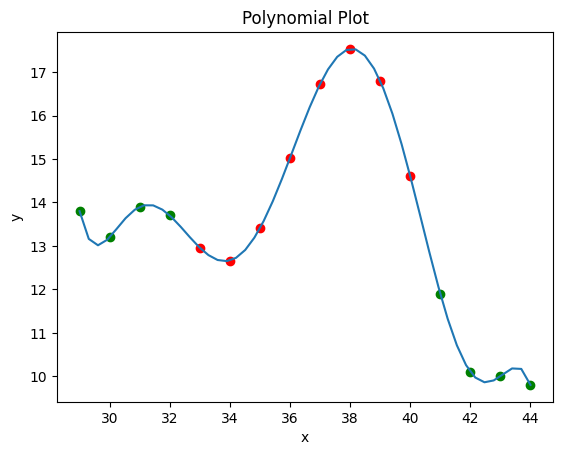

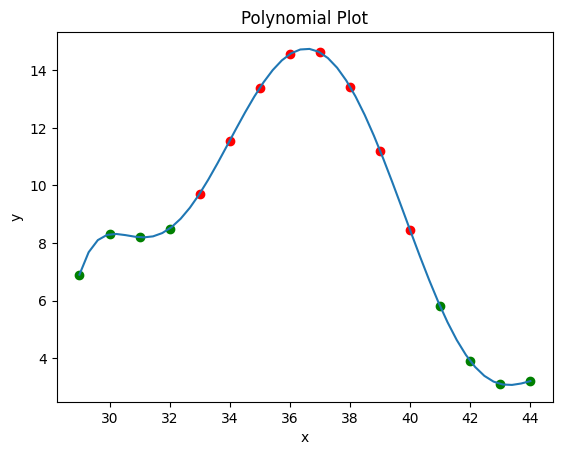

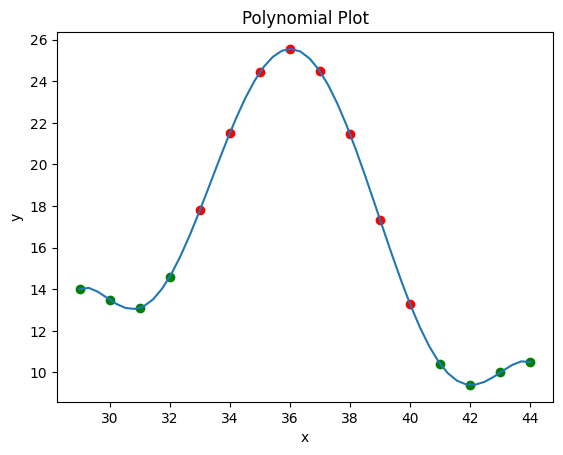

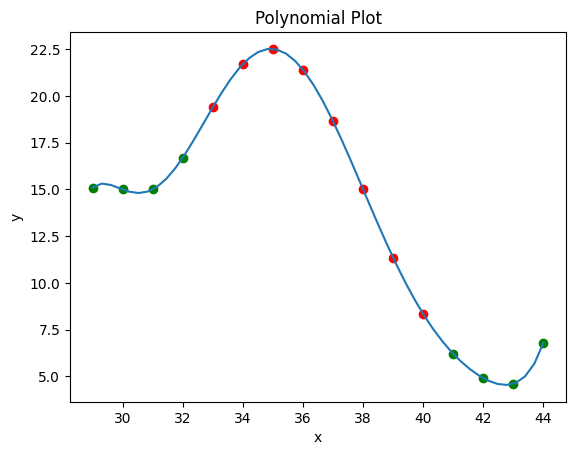

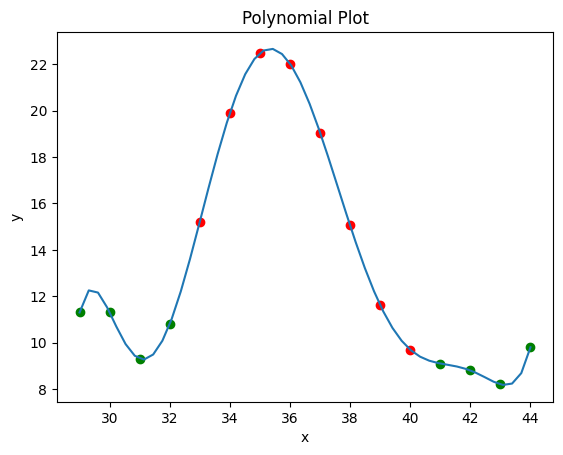

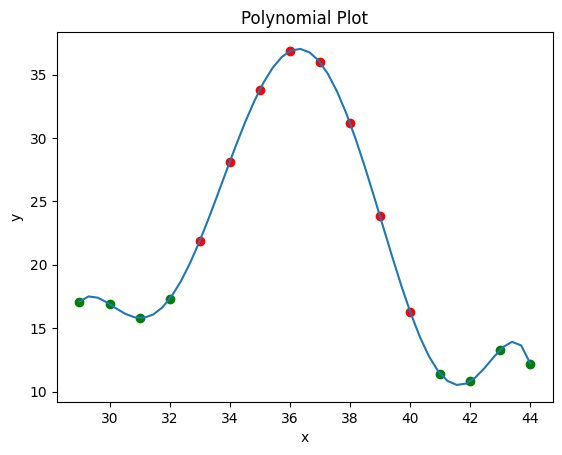

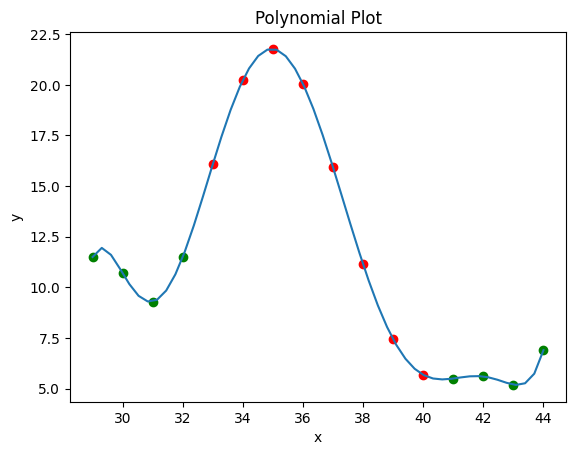

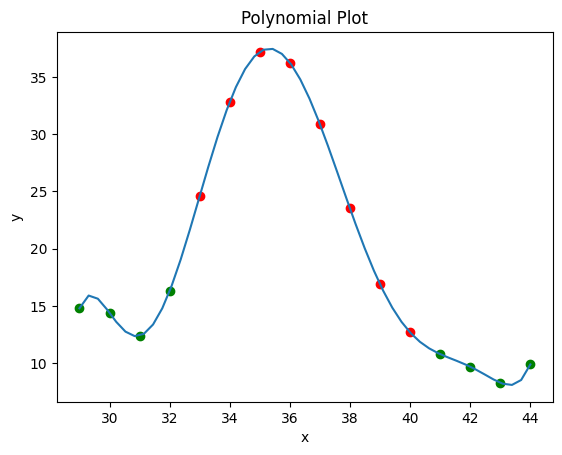

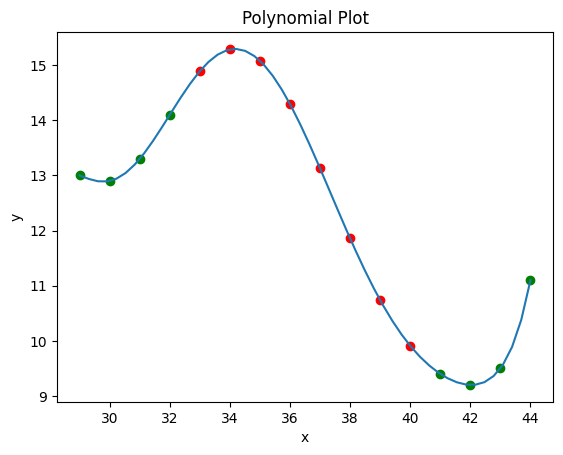

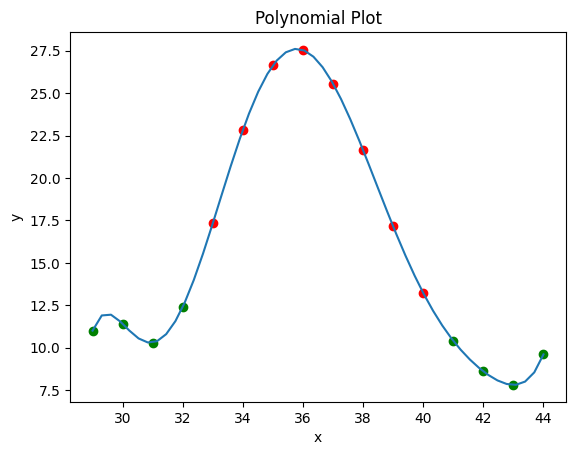

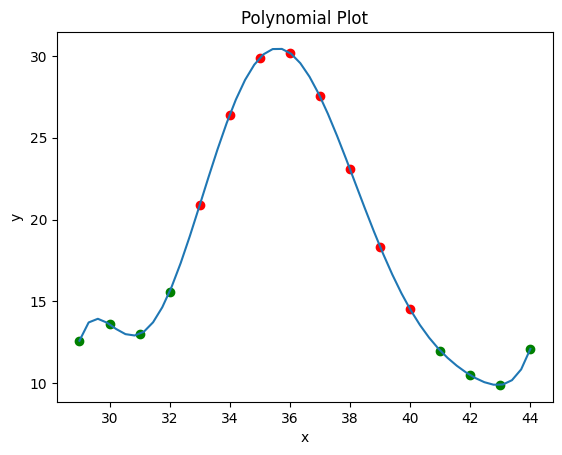

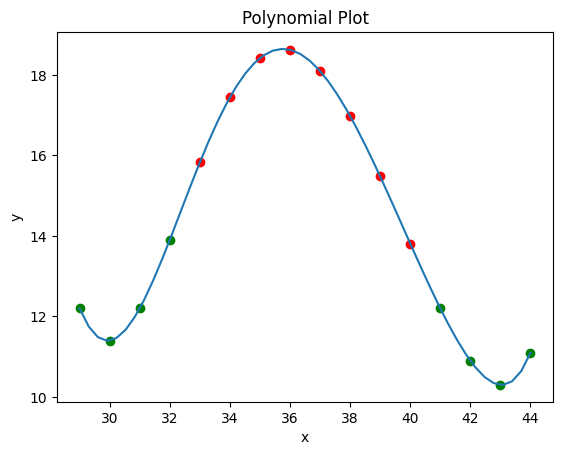

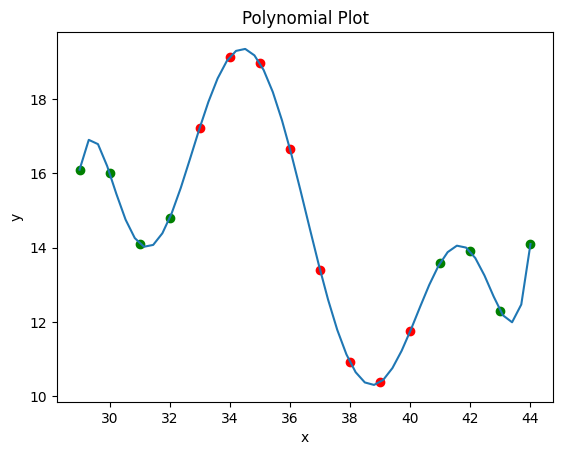

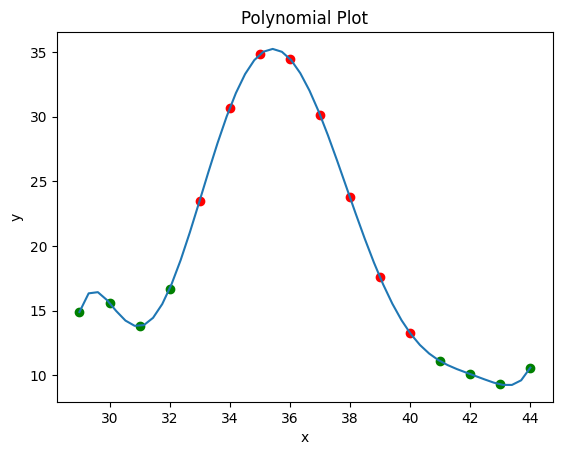

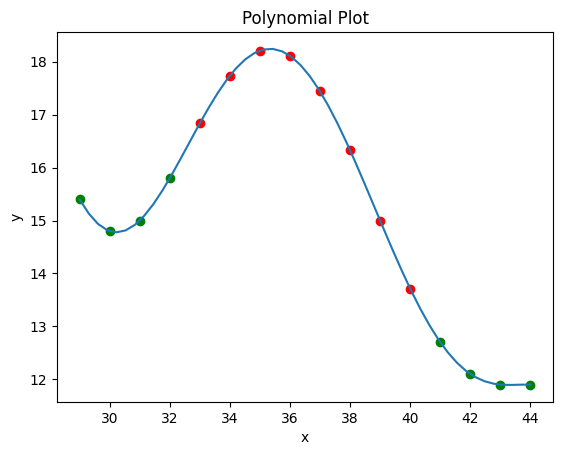

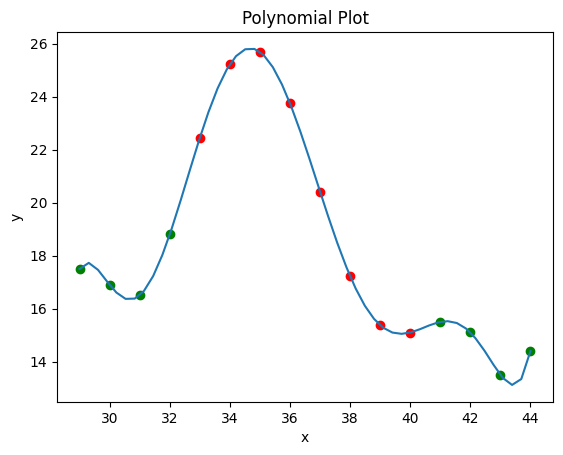

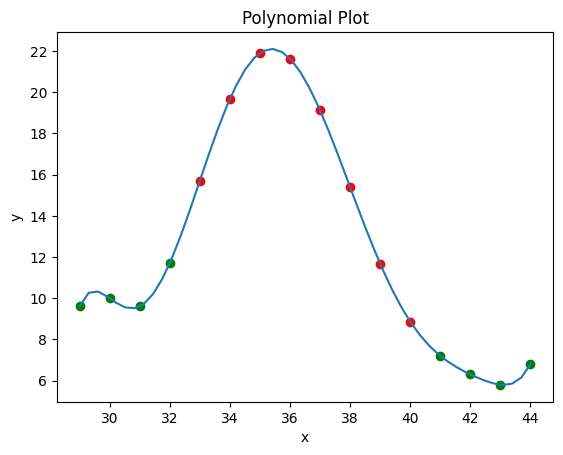

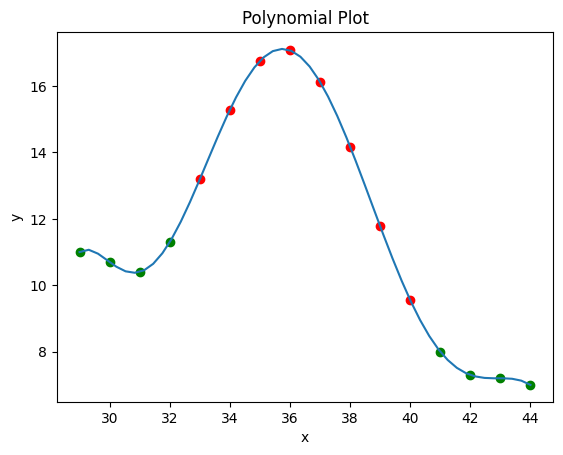

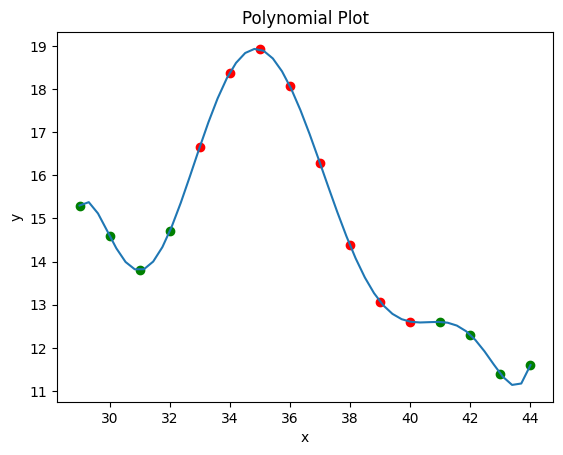

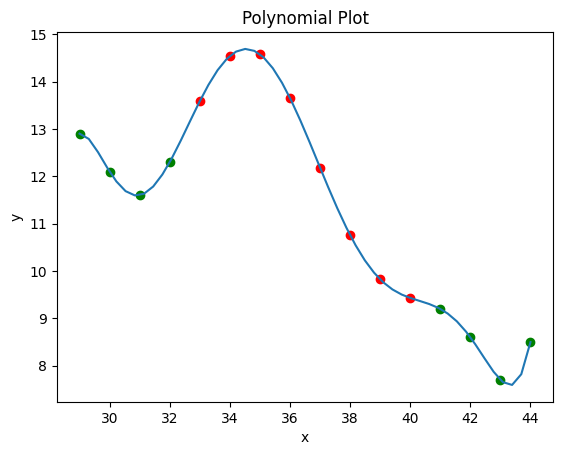

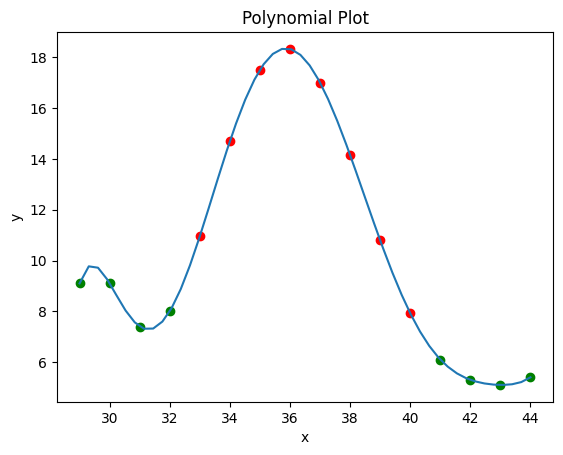

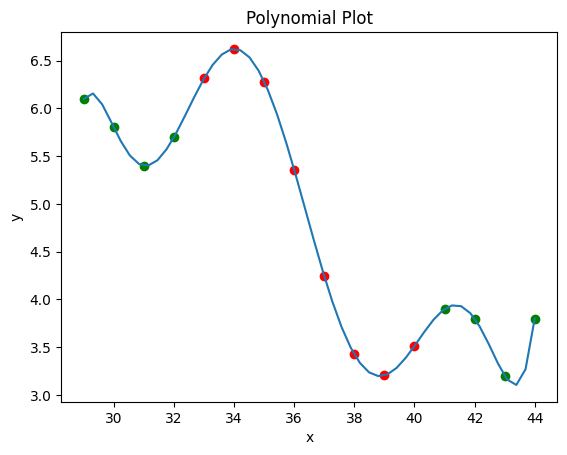

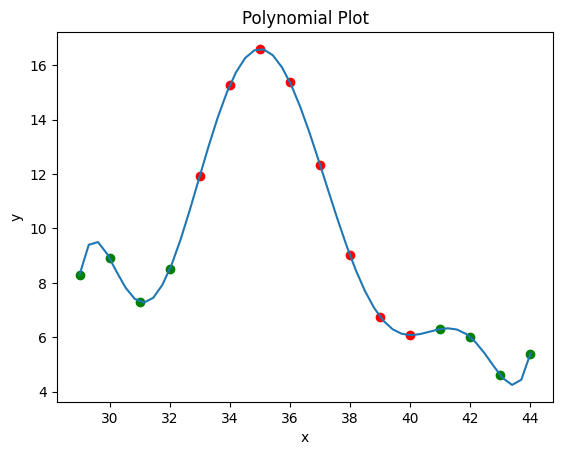

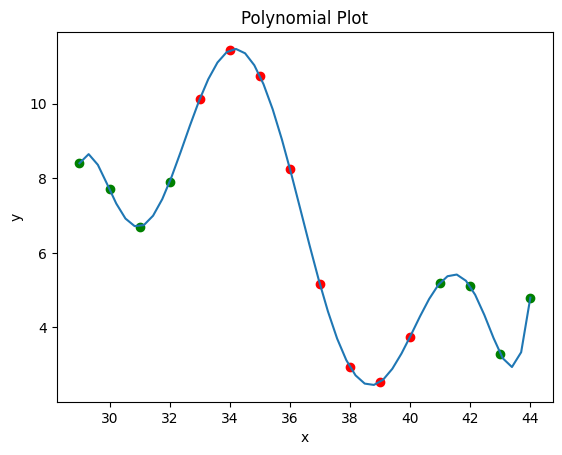

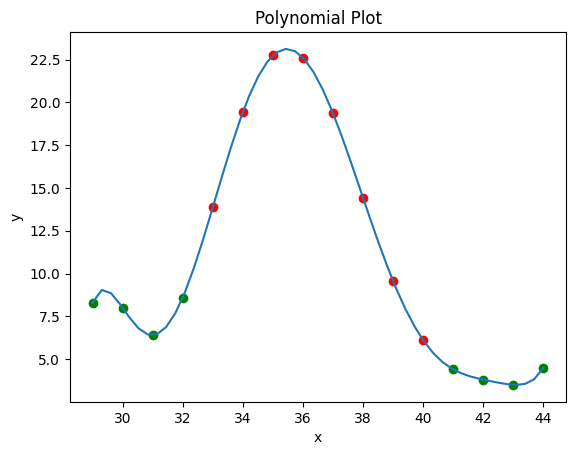

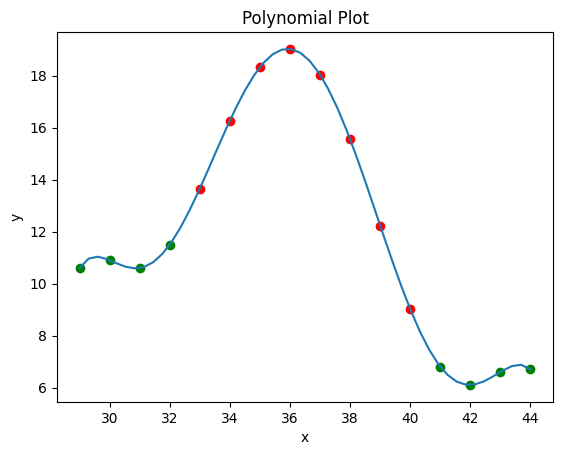

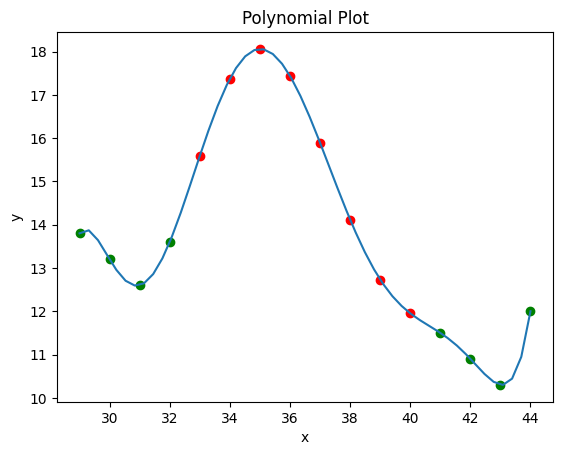

,Ano,Acre,Rondônia,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,...,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
0,2012.0,9.200000,8.100000,11.100000,8.500000,8.000000,12.600000,8.400000,7.900000,7.700000,...,7.600000,8.600000,7.800000,5.600000,4.100000,5.300000,7.600000,6.600000,6.300000,8.800000
1,2012.1,9.000000,6.300000,9.100000,5.900000,7.900000,14.700000,7.800000,9.200000,7.100000,...,7.300000,7.500000,7.500000,5.300000,3.800000,5.100000,7.100000,5.800000,5.300000,8.500000
2,2012.2,7.800000,5.900000,9.500000,7.500000,7.200000,14.200000,7.300000,7.700000,6.200000,...,6.900000,7.500000,7.000000,4.700000,3.200000,4.700000,5.000000,5.200000,5.000000,8.700000
3,2012.3,8.200000,5.200000,8.300000,8.400000,6.900000,12.100000,7.700000,7.600000,7.000000,...,6.700000,6.900000,6.800000,4.500000,2.700000,4.400000,5.000000,4.800000,5.100000,8.900000
4,2013.0,10.900000,6.200000,10.400000,8.900000,7.900000,11.500000,9.300000,9.500000,8.400000,...,7.800000,7.300000,7.800000,4.900000,3.700000,5.400000,4.800000,5.800000,6.800000,9.700000
5,2013.1,9.600000,4.900000,10.300000,8.600000,7.700000,14.500000,8.300000,9.400000,7.500000,...,7.700000,7.000000,7.500000,4.600000,3.500000,4.600000,5.000000,4.500000,5.800000,9.200000
6,2013.2,8.900000,4.600000,8.400000,8.000000,7.800000,11.000000,6.200000,7.500000,7.500000,...,7.200000,6.900000,7.400000,4.300000,2.800000,4.900000,4.400000,3.900000,5.200000,9.000000
7,2013.3,7.000000,5.000000,7.700000,6.800000,6.100000,9.200000,6.500000,5.600000,7.000000,...,5.900000,6.200000,6.600000,3.800000,2.600000,4.700000,4.500000,3.800000,3.900000,8.500000
8,2014.0,8.100000,5.000000,8.300000,7.700000,7.800000,11.400000,8.600000,6.400000,7.100000,...,6.400000,6.800000,7.300000,4.200000,3.100000,5.400000,4.700000,4.500000,5.700000,9.100000
9,2014.1,9.700000,4.200000,8.400000,5.500000,7.100000,9.900000,7.800000,7.200000,7.100000,...,6.600000,6.500000,7.100000,4.300000,2.800000,5.000000,3.900000,4.000000,5.400000,9.100000


In [7]:
df = read_csv_replace_missing_by_polynomial('desemprego_proc_pos_2012.csv', 0, 0)
df

In [8]:
def centered_moving_average(column, window_action, window_size):
    
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)
    moving_averages = []

    for i in range(start_index, end_index + 1):
        start = max(0, i - window_size)
        end = min(data_length, i + window_size + 1)
        window = data[start:end]
        moving_averages.append(np.mean(window))
        
    modified_data = data.copy()
    modified_data[start_index:end_index + 1] = moving_averages
    modified_column = pd.Series(modified_data, name=column.name)

    return modified_column

In [9]:
df_trimestral = df.copy()
for col in df_trimestral.columns:
    if col != 'index':  
        df_trimestral[col] = centered_moving_average(df_trimestral[col], (34,39), 10)
df_trimestral

,Ano,Acre,Rondônia,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,...,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
0,2012.000000,9.200000,8.100000,11.100000,8.500000,8.000000,12.600000,8.400000,7.900000,7.700000,...,7.600000,8.600000,7.800000,5.600000,4.100000,5.300000,7.600000,6.600000,6.300000,8.800000
1,2012.100000,9.000000,6.300000,9.100000,5.900000,7.900000,14.700000,7.800000,9.200000,7.100000,...,7.300000,7.500000,7.500000,5.300000,3.800000,5.100000,7.100000,5.800000,5.300000,8.500000
2,2012.200000,7.800000,5.900000,9.500000,7.500000,7.200000,14.200000,7.300000,7.700000,6.200000,...,6.900000,7.500000,7.000000,4.700000,3.200000,4.700000,5.000000,5.200000,5.000000,8.700000
3,2012.300000,8.200000,5.200000,8.300000,8.400000,6.900000,12.100000,7.700000,7.600000,7.000000,...,6.700000,6.900000,6.800000,4.500000,2.700000,4.400000,5.000000,4.800000,5.100000,8.900000
4,2013.000000,10.900000,6.200000,10.400000,8.900000,7.900000,11.500000,9.300000,9.500000,8.400000,...,7.800000,7.300000,7.800000,4.900000,3.700000,5.400000,4.800000,5.800000,6.800000,9.700000
5,2013.100000,9.600000,4.900000,10.300000,8.600000,7.700000,14.500000,8.300000,9.400000,7.500000,...,7.700000,7.000000,7.500000,4.600000,3.500000,4.600000,5.000000,4.500000,5.800000,9.200000
6,2013.200000,8.900000,4.600000,8.400000,8.000000,7.800000,11.000000,6.200000,7.500000,7.500000,...,7.200000,6.900000,7.400000,4.300000,2.800000,4.900000,4.400000,3.900000,5.200000,9.000000
7,2013.300000,7.000000,5.000000,7.700000,6.800000,6.100000,9.200000,6.500000,5.600000,7.000000,...,5.900000,6.200000,6.600000,3.800000,2.600000,4.700000,4.500000,3.800000,3.900000,8.500000
8,2014.000000,8.100000,5.000000,8.300000,7.700000,7.800000,11.400000,8.600000,6.400000,7.100000,...,6.400000,6.800000,7.300000,4.200000,3.100000,5.400000,4.700000,4.500000,5.700000,9.100000
9,2014.100000,9.700000,4.200000,8.400000,5.500000,7.100000,9.900000,7.800000,7.200000,7.100000,...,6.600000,6.500000,7.100000,4.300000,2.800000,5.000000,3.900000,4.000000,5.400000,9.100000


In [10]:
df_ano = df_trimestral.copy()
df_ano = df_ano.set_index('Ano')

df_ano.index = df_ano.index.astype(str).str.split('.').str[0]
df_avg = df_ano.groupby(['Ano']).mean()
df_avg


,Acre,Rondônia,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,...,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
Ano,,,,,,,,,,,,,,,,,,,,,
2012,8.550000,6.375000,9.500000,7.575000,7.500000,13.400000,7.800000,8.100000,7.000000,7.800000,...,7.125000,7.625000,7.275000,5.025000,3.450000,4.875000,6.175000,5.600000,5.425000,8.725000
2013,9.100000,5.175000,9.200000,8.075000,7.375000,11.550000,7.575000,8.000000,7.600000,7.900000,...,7.150000,6.850000,7.325000,4.400000,3.150000,4.900000,4.675000,4.500000,5.425000,9.100000
2014,7.800000,4.250000,7.850000,6.500000,7.300000,10.425000,7.625000,6.900000,6.600000,7.425000,...,6.275000,6.325000,7.225000,4.125000,2.900000,5.075000,4.150000,4.100000,5.375000,9.000000
2015,8.600000,5.650000,9.700000,8.600000,9.000000,11.200000,8.725000,8.750000,7.675000,8.950000,...,7.850000,7.725000,9.475000,5.925000,4.175000,6.375000,6.225000,6.150000,7.425000,10.200000
2016,11.025000,8.025000,13.825000,8.875000,11.325000,15.775000,11.525000,12.100000,9.575000,12.100000,...,12.375000,11.925000,12.450000,8.300000,6.375000,8.325000,7.675000,9.500000,10.600000,12.100000
2017,14.250000,8.275000,15.850000,10.000000,11.850000,18.100000,11.700000,14.475000,13.075000,12.750000,...,13.275000,15.100000,13.525000,9.050000,7.150000,8.550000,8.575000,9.050000,10.625000,13.325000
2018,13.725000,9.225000,14.025000,12.475000,11.225000,20.375000,10.700000,14.650000,12.925000,11.400000,...,11.675000,15.075000,13.450000,8.850000,6.425000,8.200000,7.625000,7.950000,9.300000,12.775000
2019,14.800000,8.125000,14.150000,15.075000,10.875000,17.525000,11.000000,14.525000,13.050000,11.050000,...,11.100000,14.775000,12.550000,8.650000,6.150000,8.125000,8.075000,7.975000,10.725000,13.450000
2020,13.620681,9.065651,16.143513,14.944522,13.055053,20.831103,12.066663,19.290347,12.935244,15.143042,...,11.814036,14.965735,11.932074,10.026738,5.276065,9.400132,7.281626,10.759153,11.911236,13.939721


In [11]:
df_until_2012 = df_2014.copy()
df_until_2012 = df_until_2012.iloc[:-3]
df_until_2012

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1992,9.216314,8.980849,11.55573,5.92294,8.211435,5.710858,8.416935,7.296177,6.66365,3.358037,...,6.054656,7.165673,8.196342,7.431412,6.698602,5.154645,4.260728,7.43793,8.810622,6.100175
1993,10.05649,11.086582,16.032611,8.304413,7.681225,5.335375,9.475439,6.077933,5.822818,3.607978,...,5.375051,8.010937,7.681198,7.250549,5.913455,4.851567,3.348243,9.922345,7.827288,5.300097
1995,9.80071,8.312264,11.311703,13.067481,7.45973,5.735904,8.233751,5.015059,7.133533,3.317694,...,6.364125,7.511759,7.31991,7.659531,13.727837,5.933302,3.642741,7.636,8.02107,7.599651
1996,8.437029,8.011287,10.816192,7.528157,8.524951,5.994351,12.910183,6.764575,8.095008,3.57012,...,6.104889,8.593678,6.496756,5.625785,13.094003,6.850794,4.44975,9.298501,9.054236,6.020697
1997,8.887605,7.972121,15.131507,10.932264,8.366323,7.107643,10.255129,6.932531,7.258219,4.542337,...,7.451048,9.408432,10.088293,6.551033,3.705357,7.995407,4.993038,7.306369,10.557259,8.674082
1998,8.53551,12.287512,18.481736,10.538872,8.734137,7.257648,12.260437,7.363315,8.600943,4.45229,...,8.429585,10.949554,8.109205,6.542544,7.510324,8.633985,7.590661,11.415608,12.761422,6.550195
1999,12.203437,14.748984,19.326194,15.278558,9.92229,7.35609,15.22804,8.801633,9.487636,5.013055,...,9.938677,11.482436,10.267647,9.425285,7.497685,8.444023,8.12387,10.196662,12.920109,6.078458
2001,8.558123,12.065698,10.684138,19.057839,10.603811,7.983141,14.697847,10.093378,8.508379,7.897115,...,8.476753,12.460144,9.064111,9.02379,8.860495,7.627902,4.49397,12.743467,11.451631,6.955401
2002,6.582788,9.080515,12.966133,20.539464,10.735432,8.857219,14.215385,10.666093,6.903738,5.929567,...,7.704473,11.712196,7.255709,6.878789,5.89899,7.708314,4.990287,10.988206,11.819351,8.634615


In [12]:
df_appended = df_until_2012.append(df_avg)
df_appended.to_csv('desemprego_processado.csv', index=True)
df_appended

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1992,9.216314,8.980849,11.55573,5.92294,8.211435,5.710858,8.416935,7.296177,6.66365,3.358037,...,6.054656,7.165673,8.196342,7.431412,6.698602,5.154645,4.260728,7.43793,8.810622,6.100175
1993,10.05649,11.086582,16.032611,8.304413,7.681225,5.335375,9.475439,6.077933,5.822818,3.607978,...,5.375051,8.010937,7.681198,7.250549,5.913455,4.851567,3.348243,9.922345,7.827288,5.300097
1995,9.80071,8.312264,11.311703,13.067481,7.45973,5.735904,8.233751,5.015059,7.133533,3.317694,...,6.364125,7.511759,7.31991,7.659531,13.727837,5.933302,3.642741,7.636,8.02107,7.599651
1996,8.437029,8.011287,10.816192,7.528157,8.524951,5.994351,12.910183,6.764575,8.095008,3.57012,...,6.104889,8.593678,6.496756,5.625785,13.094003,6.850794,4.44975,9.298501,9.054236,6.020697
1997,8.887605,7.972121,15.131507,10.932264,8.366323,7.107643,10.255129,6.932531,7.258219,4.542337,...,7.451048,9.408432,10.088293,6.551033,3.705357,7.995407,4.993038,7.306369,10.557259,8.674082
1998,8.53551,12.287512,18.481736,10.538872,8.734137,7.257648,12.260437,7.363315,8.600943,4.45229,...,8.429585,10.949554,8.109205,6.542544,7.510324,8.633985,7.590661,11.415608,12.761422,6.550195
1999,12.203437,14.748984,19.326194,15.278558,9.92229,7.35609,15.22804,8.801633,9.487636,5.013055,...,9.938677,11.482436,10.267647,9.425285,7.497685,8.444023,8.12387,10.196662,12.920109,6.078458
2001,8.558123,12.065698,10.684138,19.057839,10.603811,7.983141,14.697847,10.093378,8.508379,7.897115,...,8.476753,12.460144,9.064111,9.02379,8.860495,7.627902,4.49397,12.743467,11.451631,6.955401
2002,6.582788,9.080515,12.966133,20.539464,10.735432,8.857219,14.215385,10.666093,6.903738,5.929567,...,7.704473,11.712196,7.255709,6.878789,5.89899,7.708314,4.990287,10.988206,11.819351,8.634615


In [13]:
def plot_column(column, color):
    plt.figure(figsize=(12, 6))
    plt.plot(column.index, column.values, color=color)
    plt.xlabel(column.index.name)
    plt.ylabel('% de desemprego')
    plt.title(column.name)  # Set the column name as the graph title
    plt.xticks(rotation=45)
    plt.show()

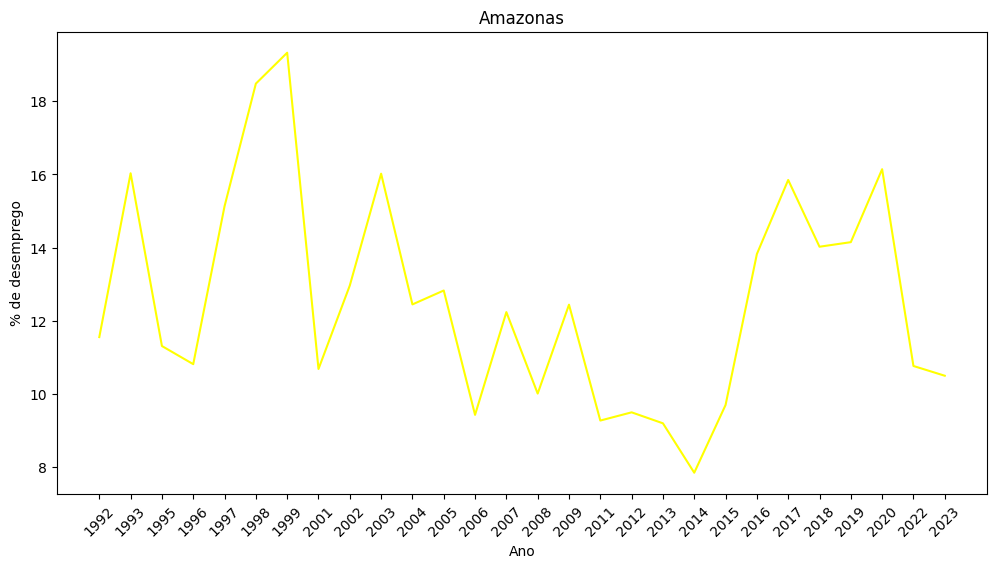

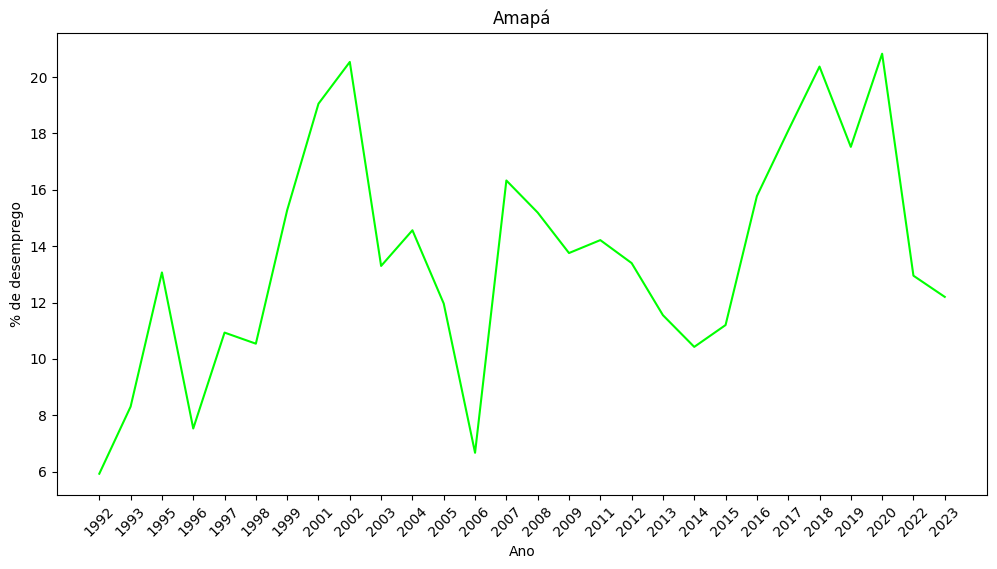

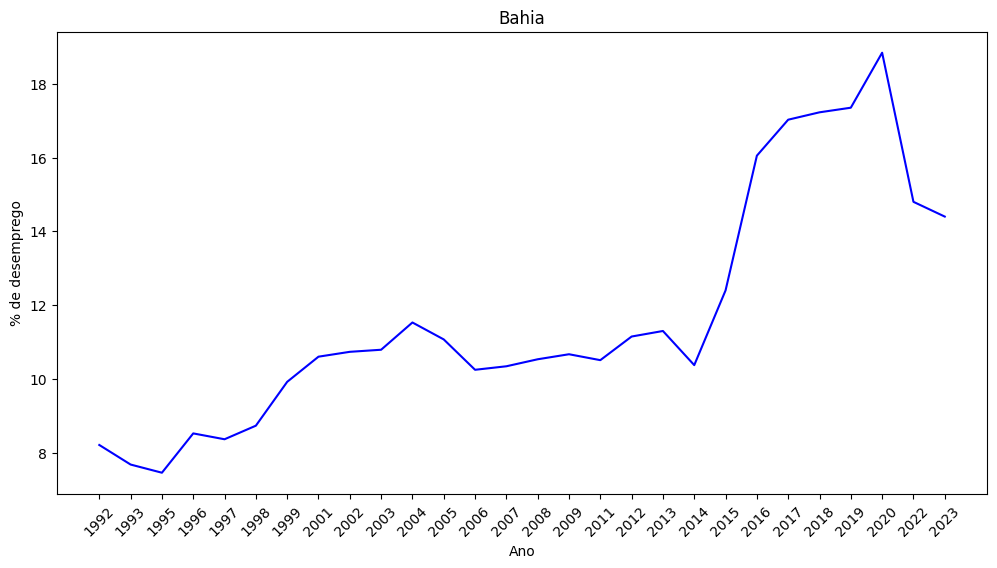

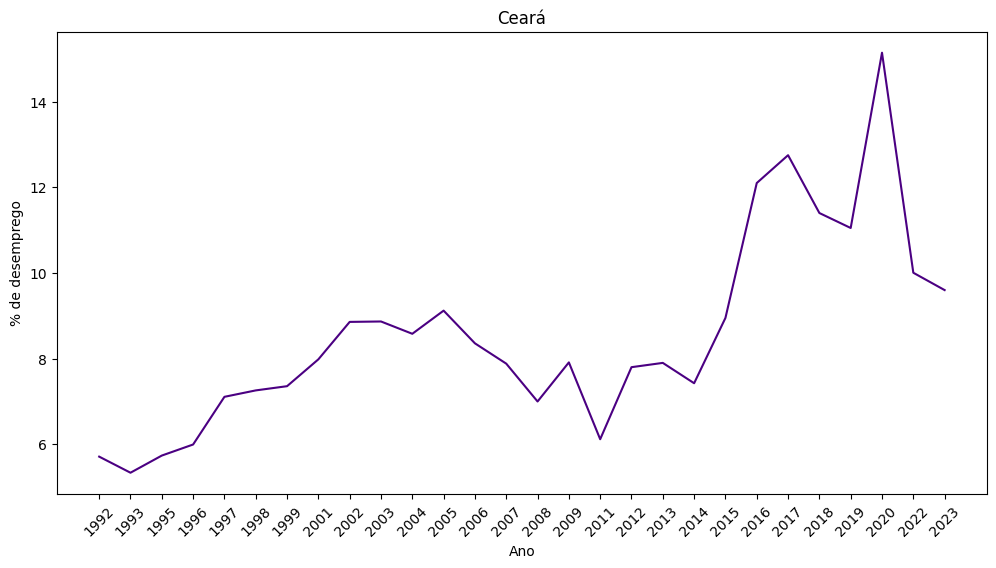

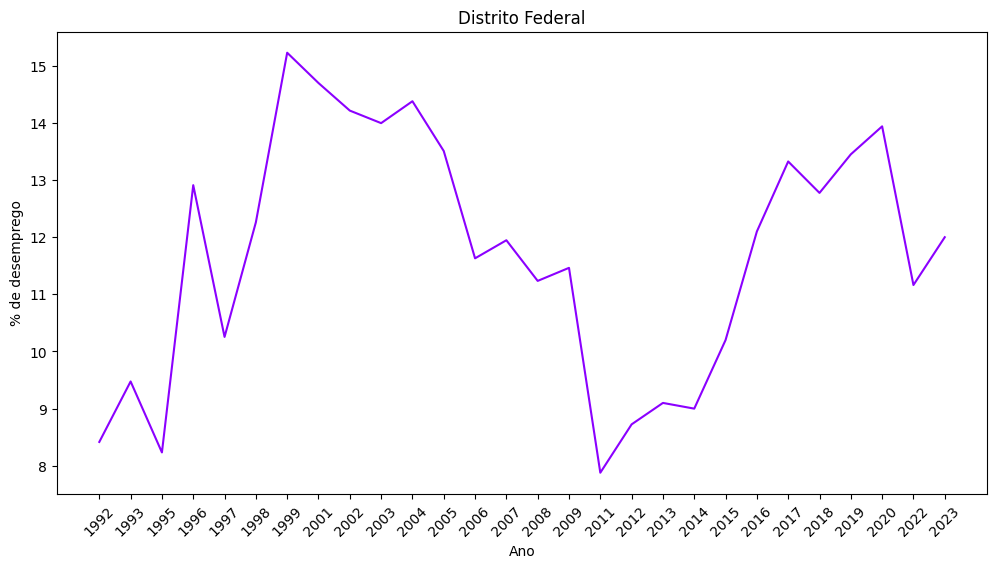

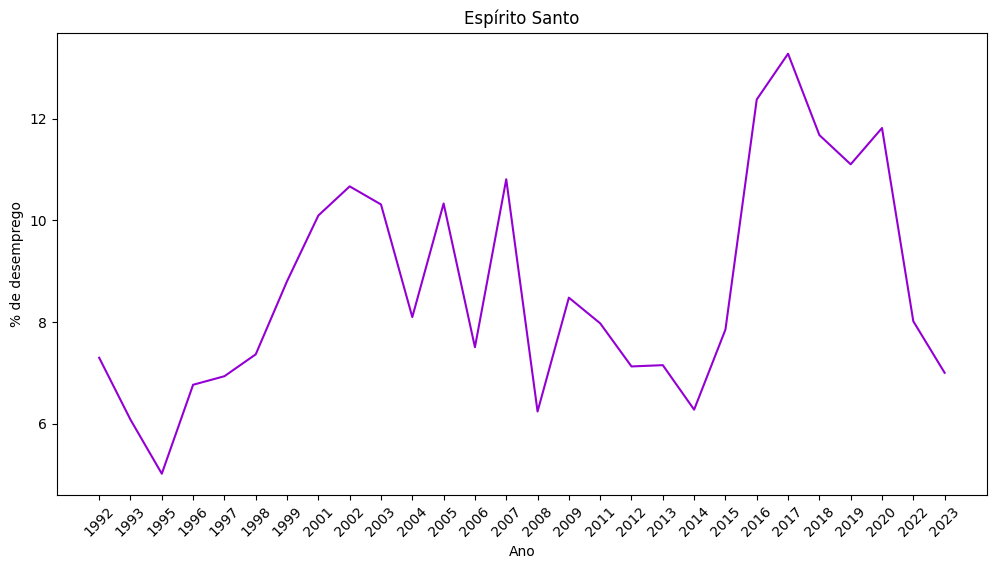

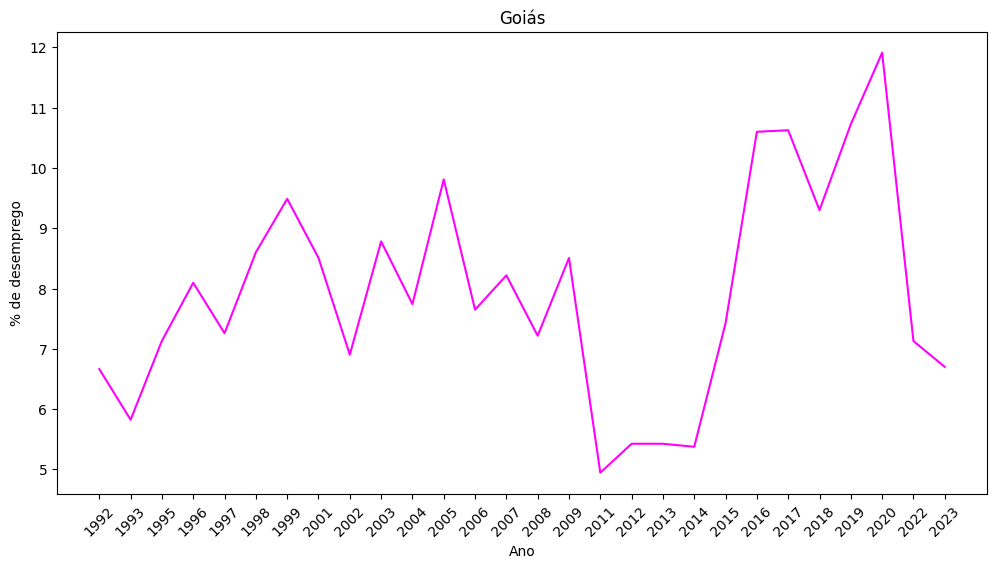

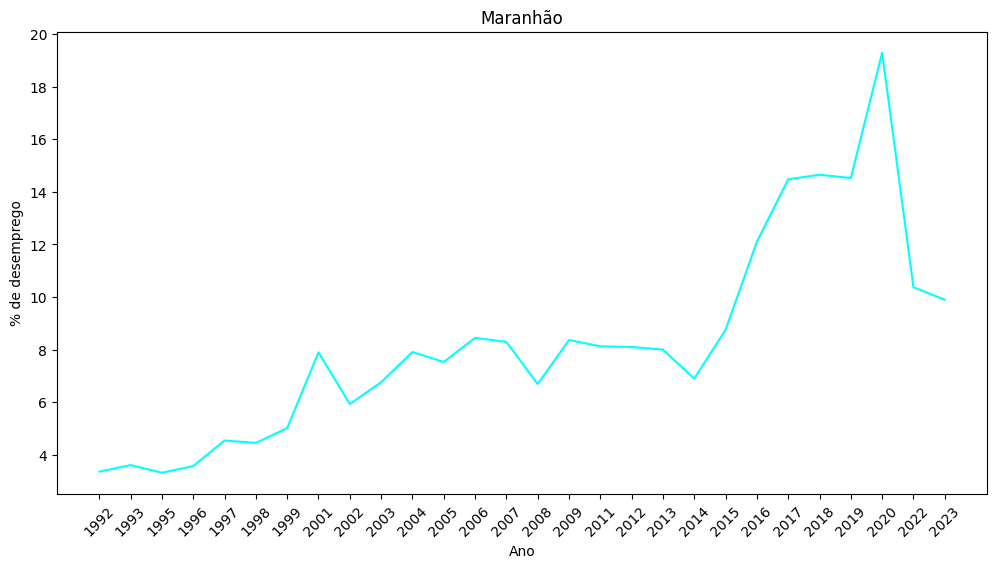

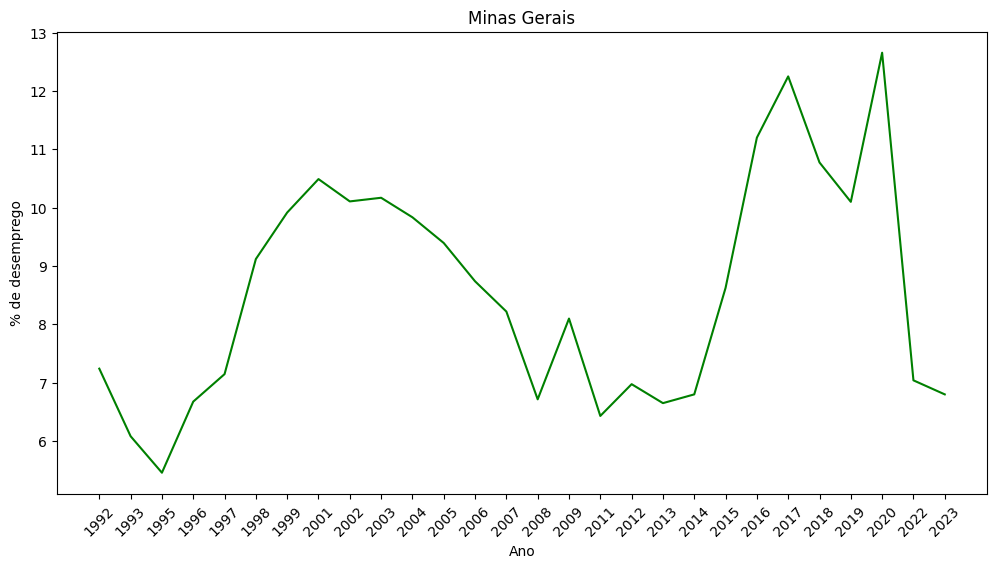

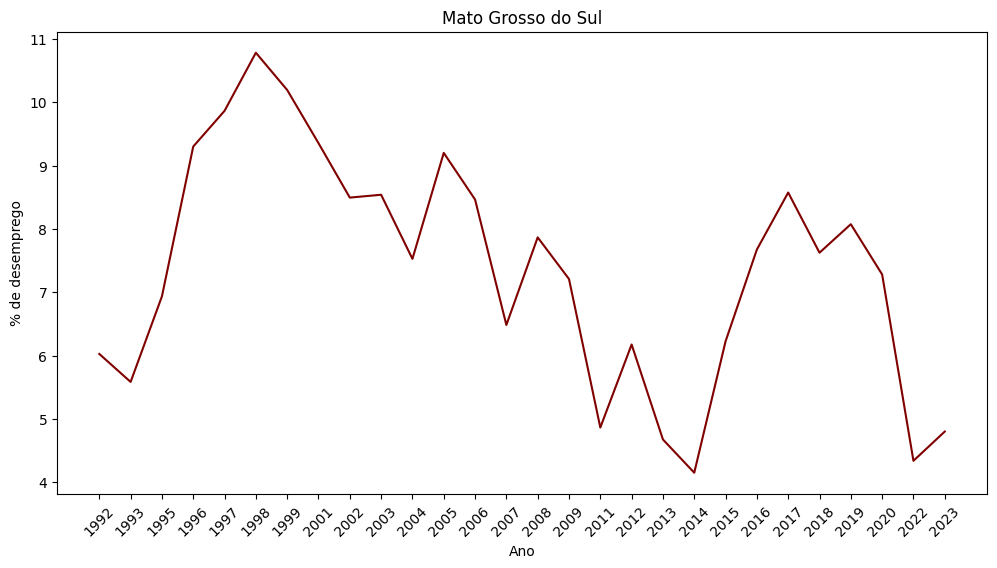

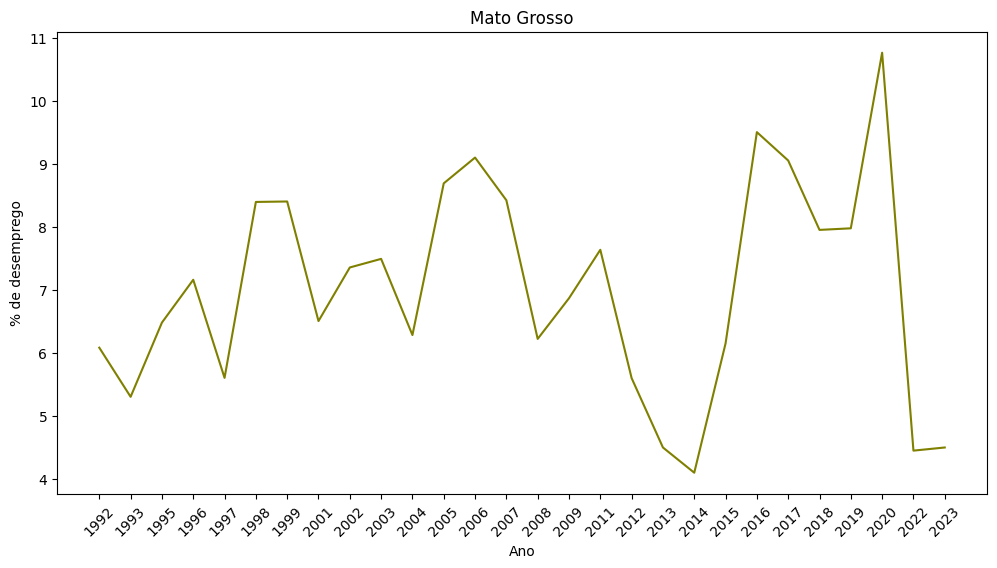

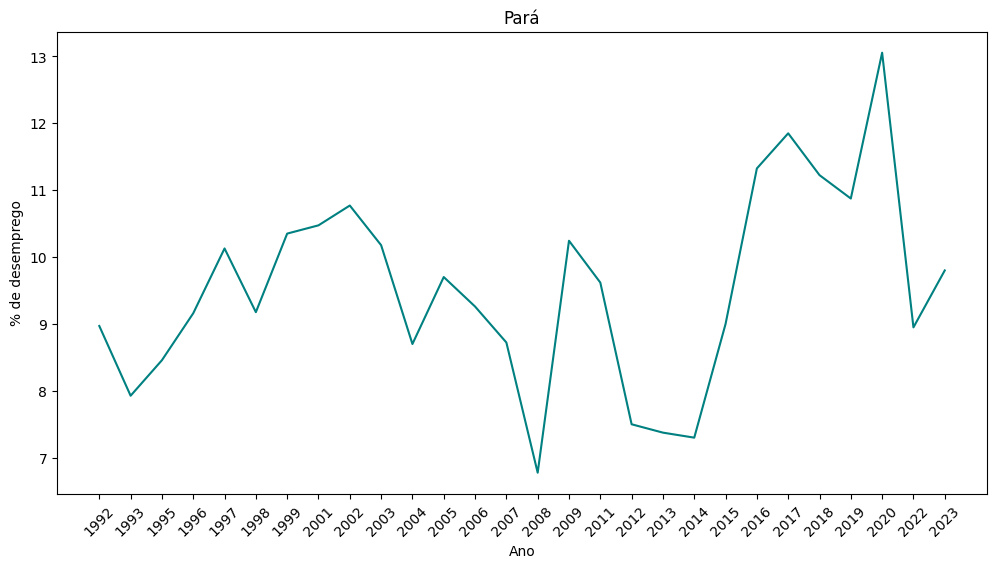

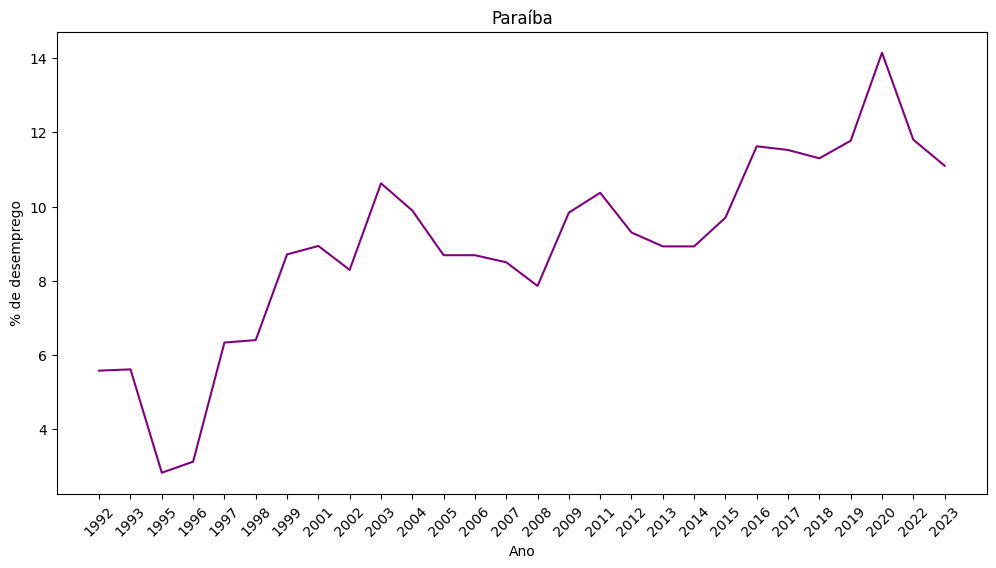

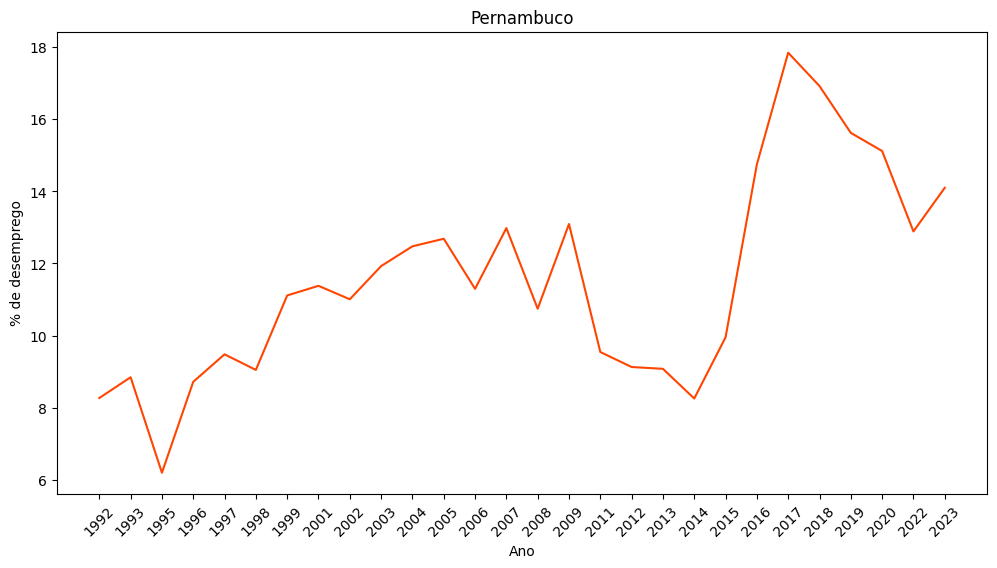

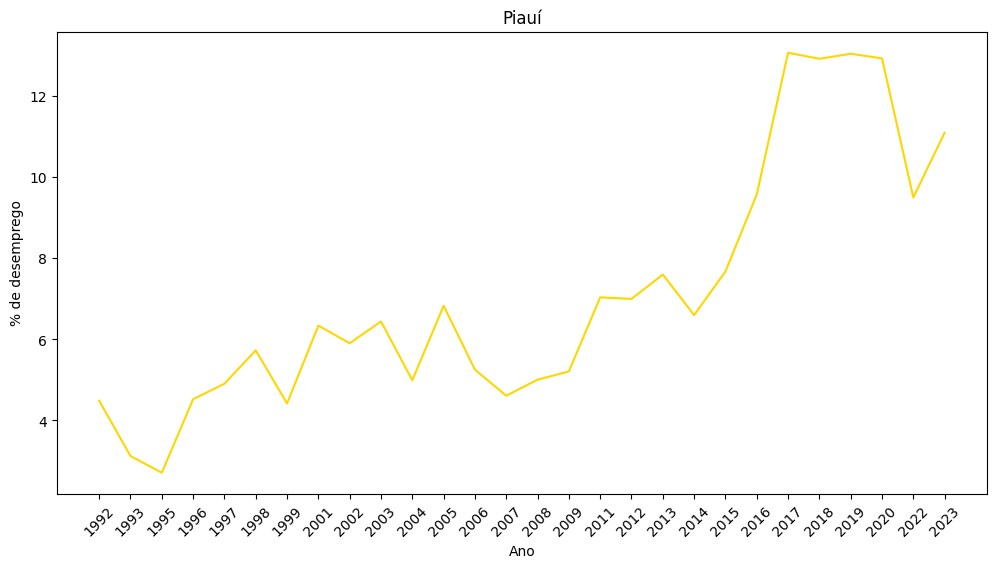

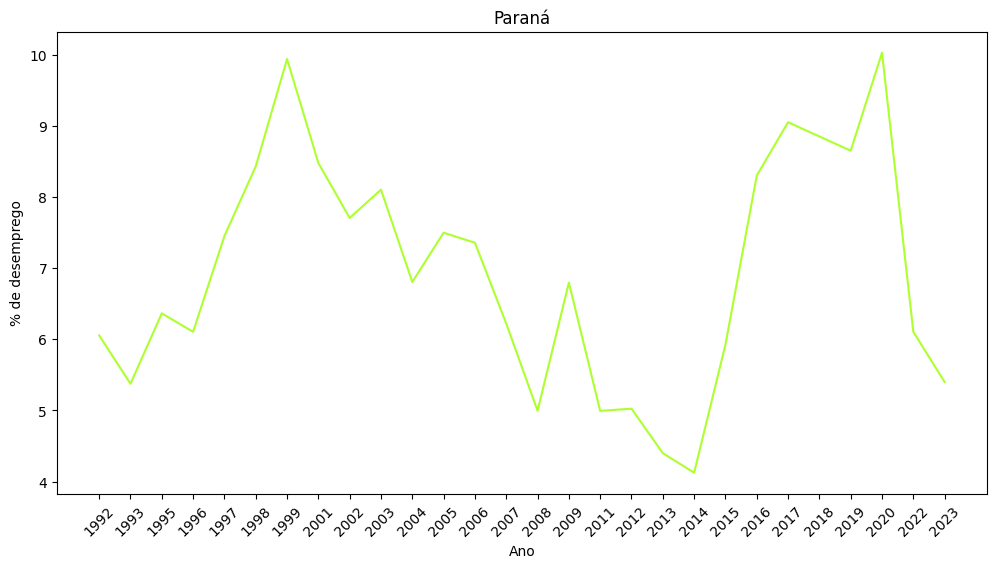

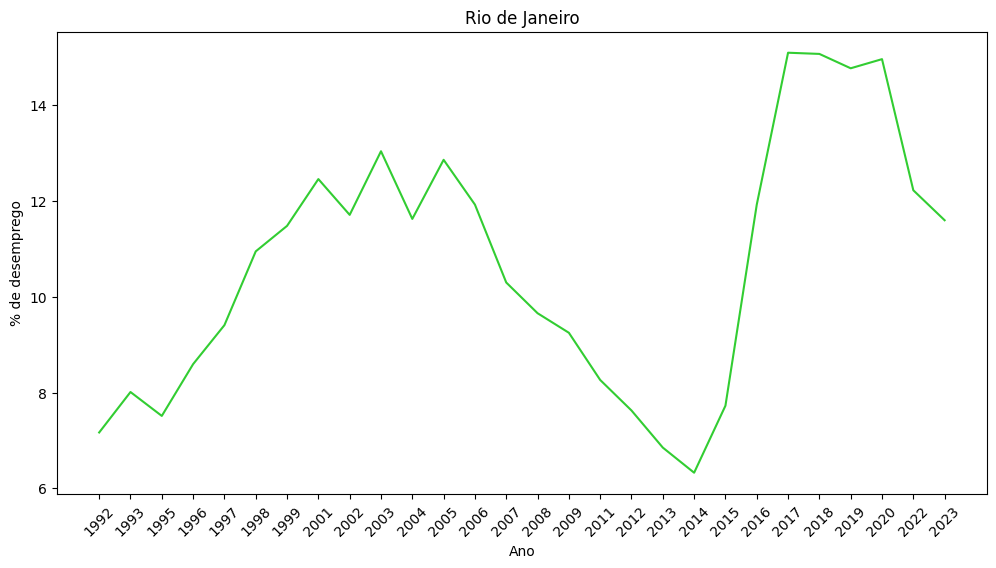

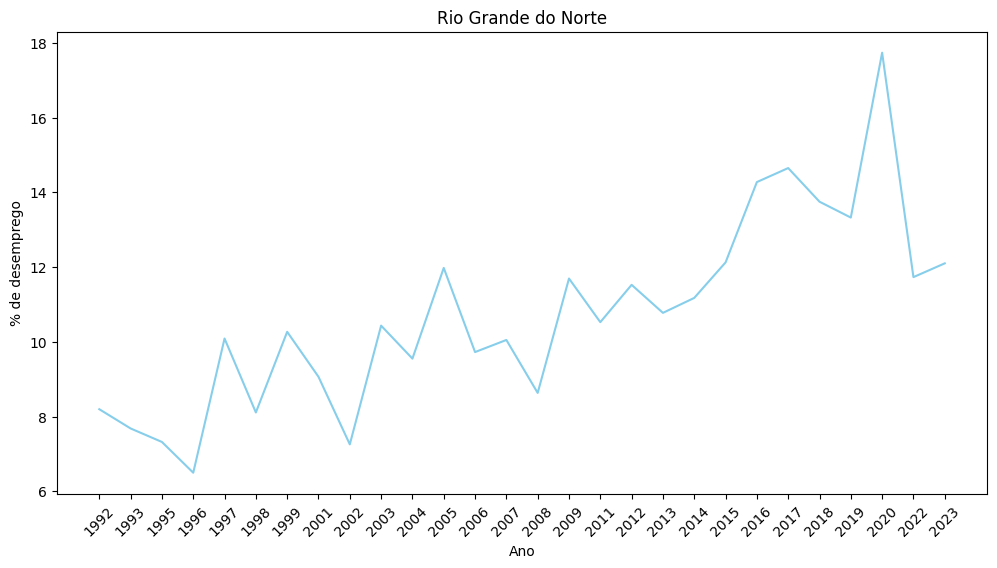

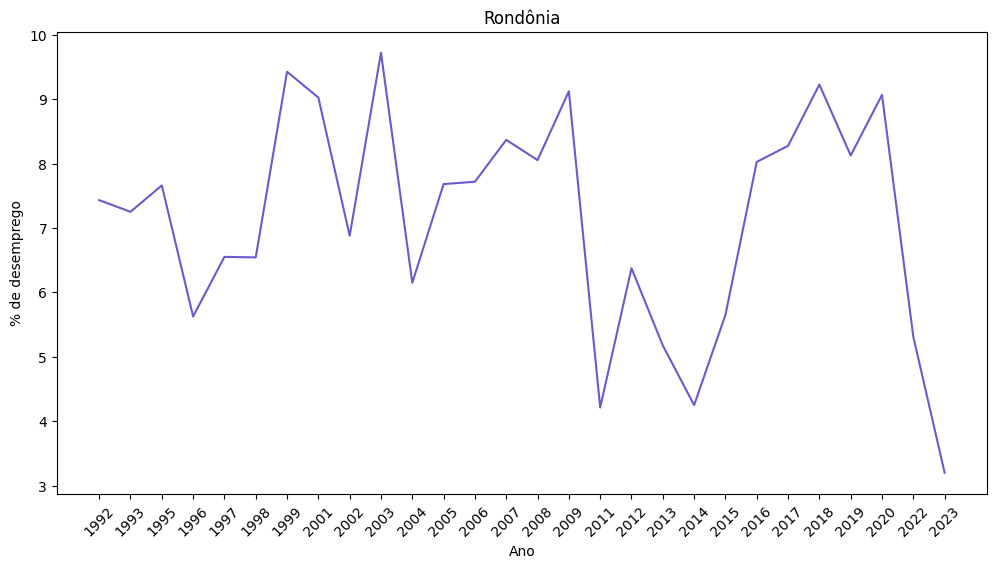

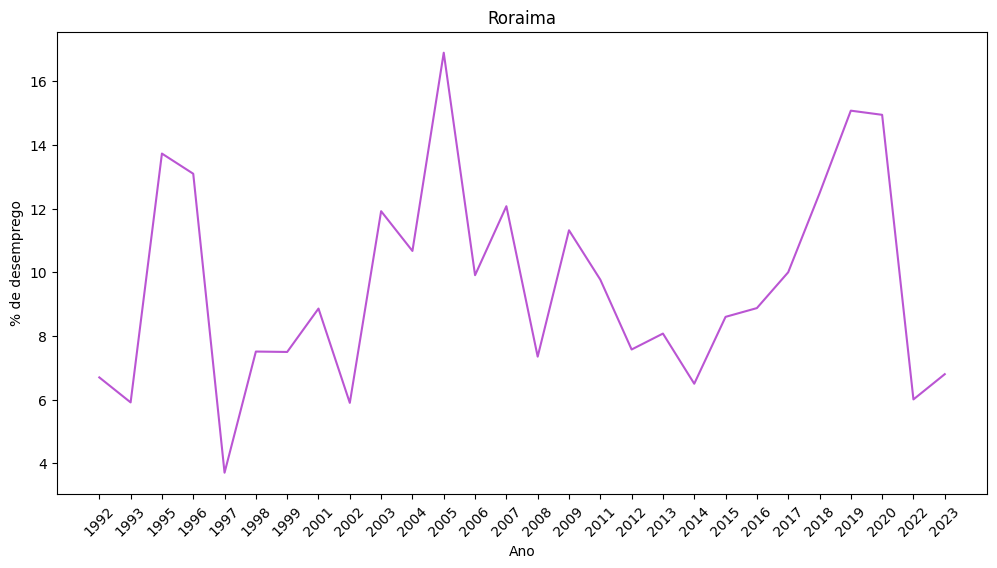

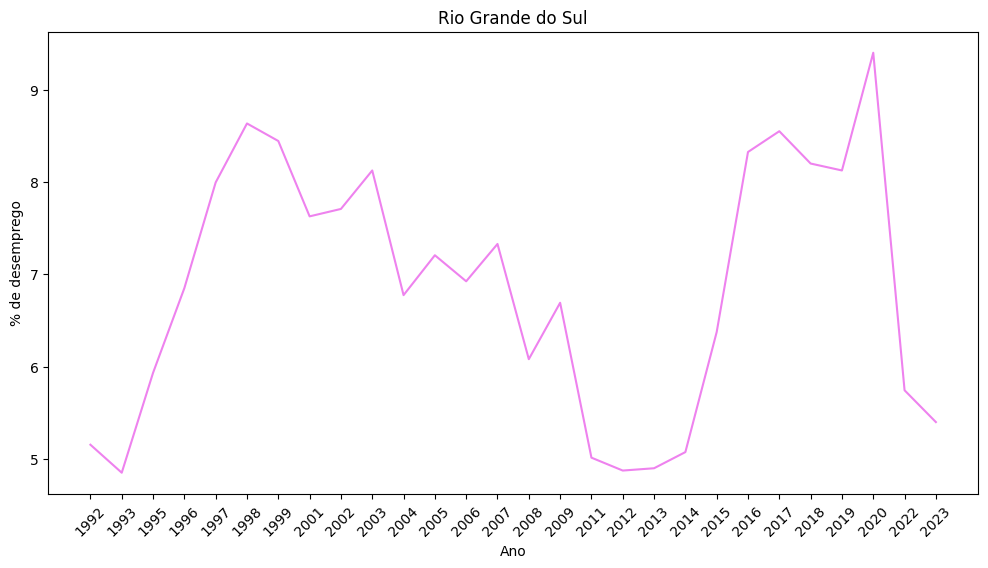

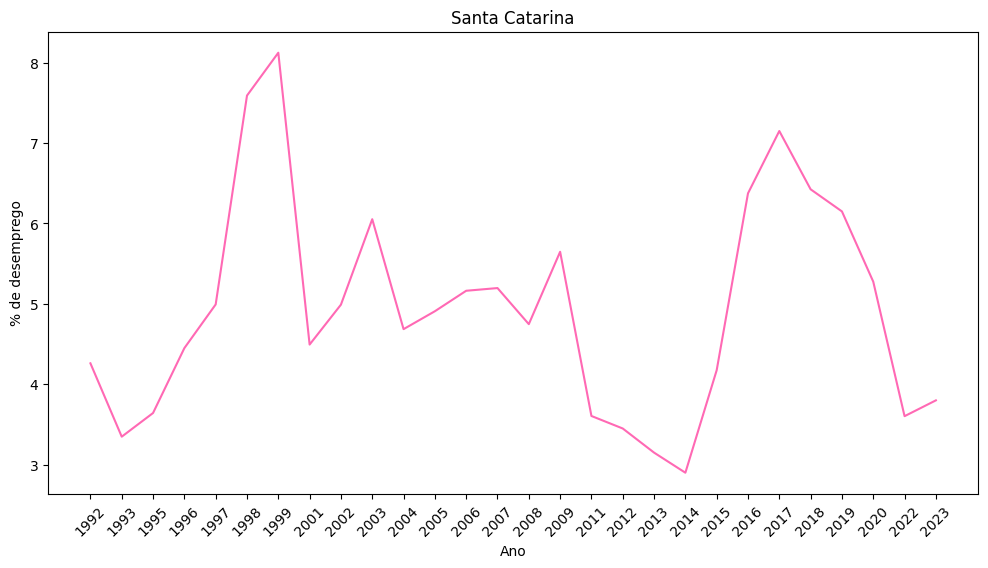

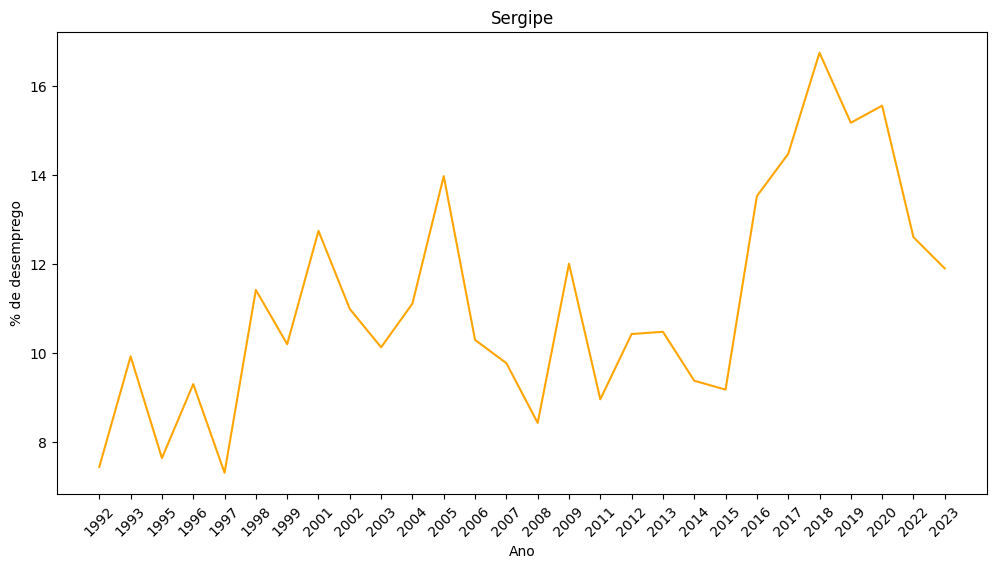

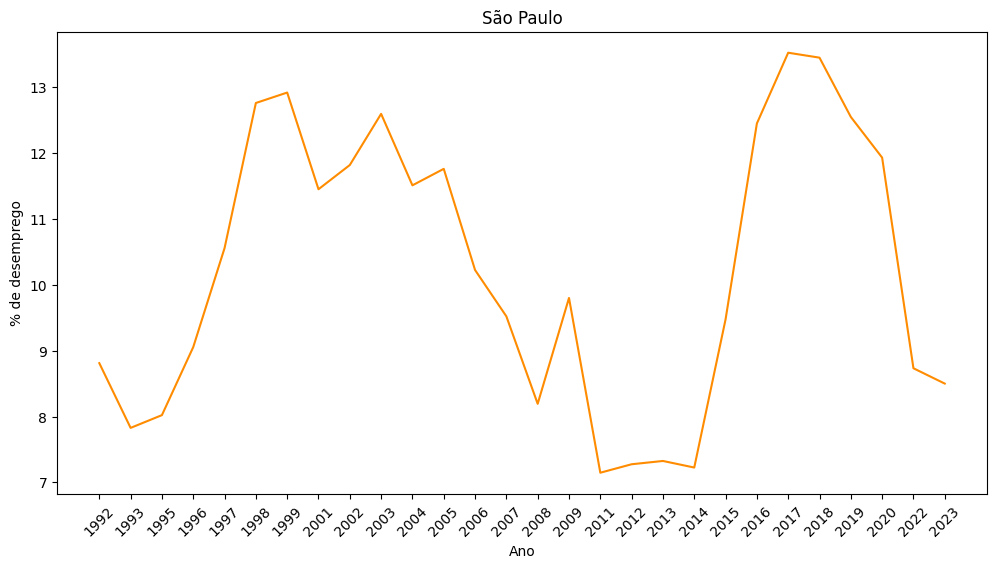

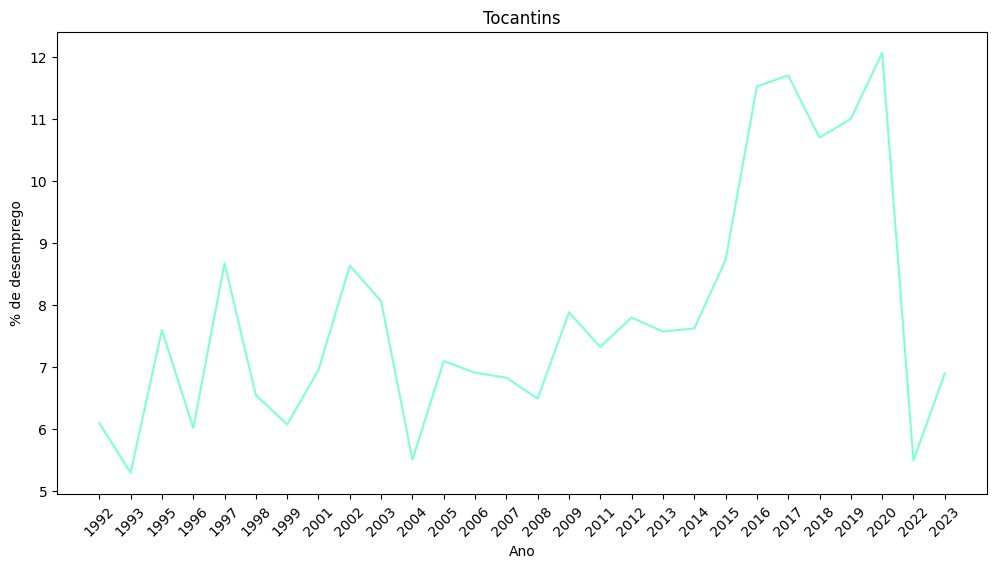

In [14]:
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF', '#9400D3', '#FF00FF',
          '#00FFFF', '#008000', '#800000', '#808000', '#008080', '#800080', '#FF4500', '#FFD700', '#ADFF2F',
          '#32CD32', '#87CEEB', '#6A5ACD', '#BA55D3', '#EE82EE', '#FF69B4', '#FFA500', '#FF8C00', '#7FFFD4',
          '#00CED1']

for i, column in enumerate(df_appended.columns):
    if i > 1:
        plot_column(df_appended[column], color=colors[i])

In [16]:
df_cma = df_appended.copy()
df_cma = df_cma.reset_index()
for col in df_cma.columns:
    if col != 'index' and col != 'Ano':  
        df_cma[col] = centered_moving_average(df_cma[col], (0,len(df_cma) - 1), 4)
        
df_cma = df_cma.set_index('Ano')

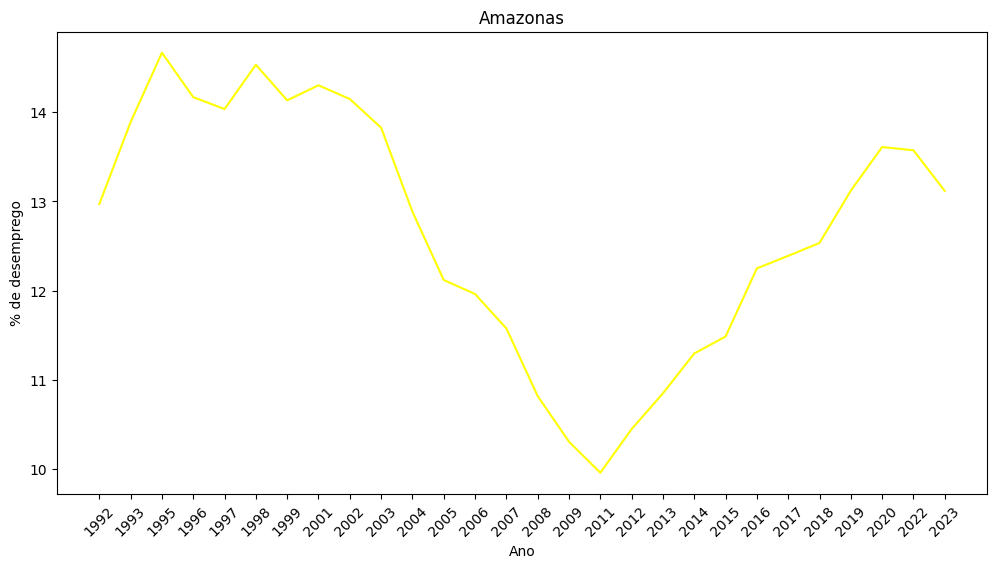

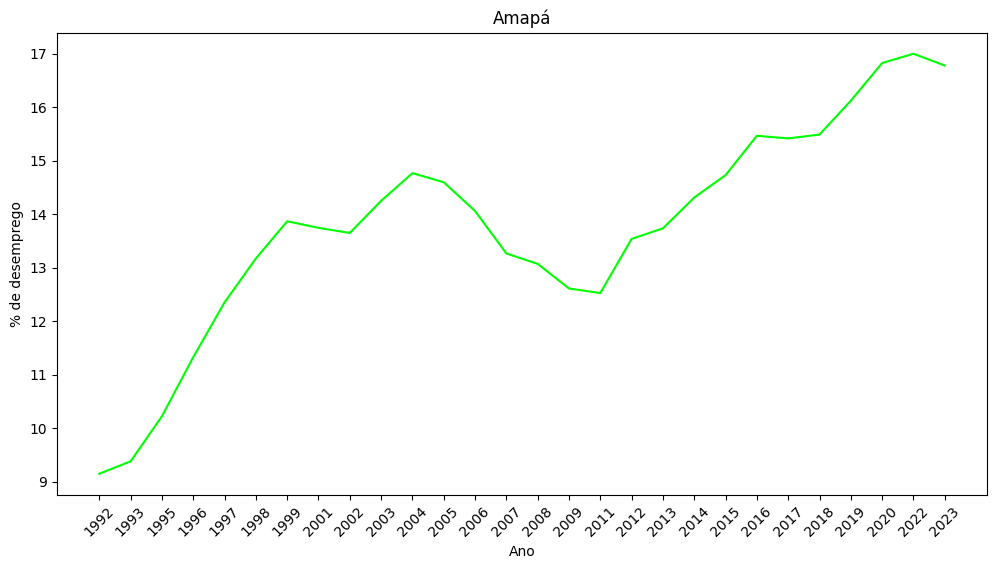

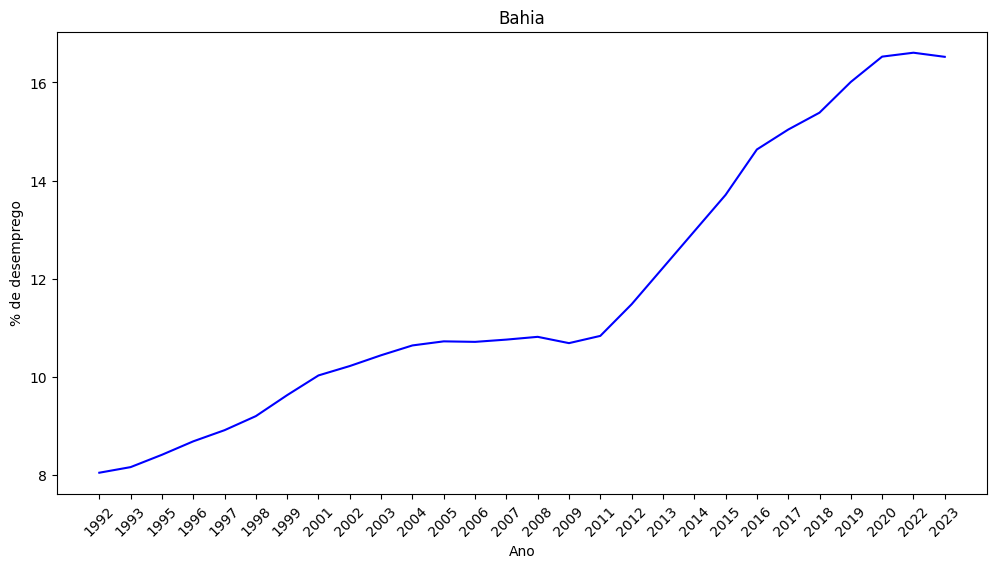

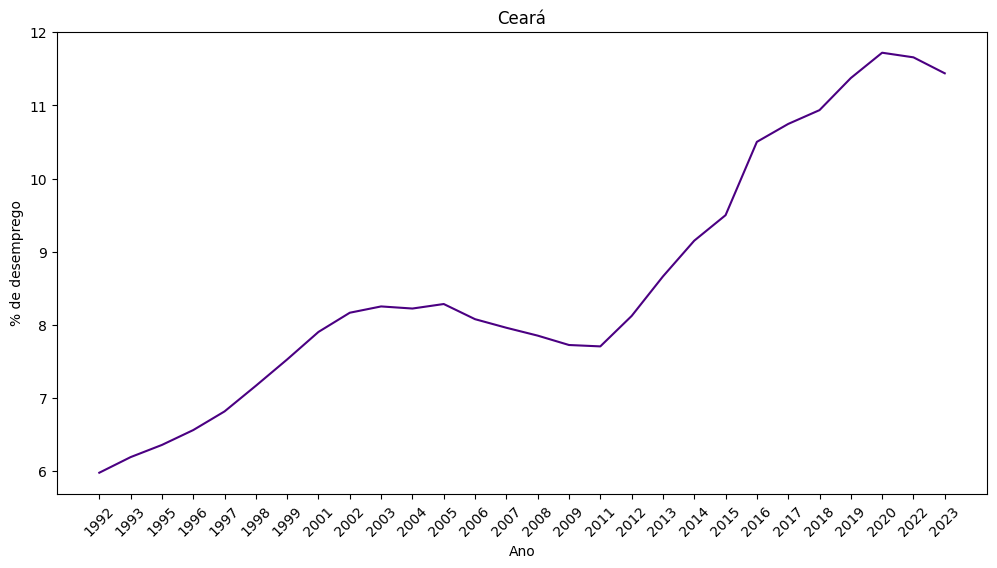

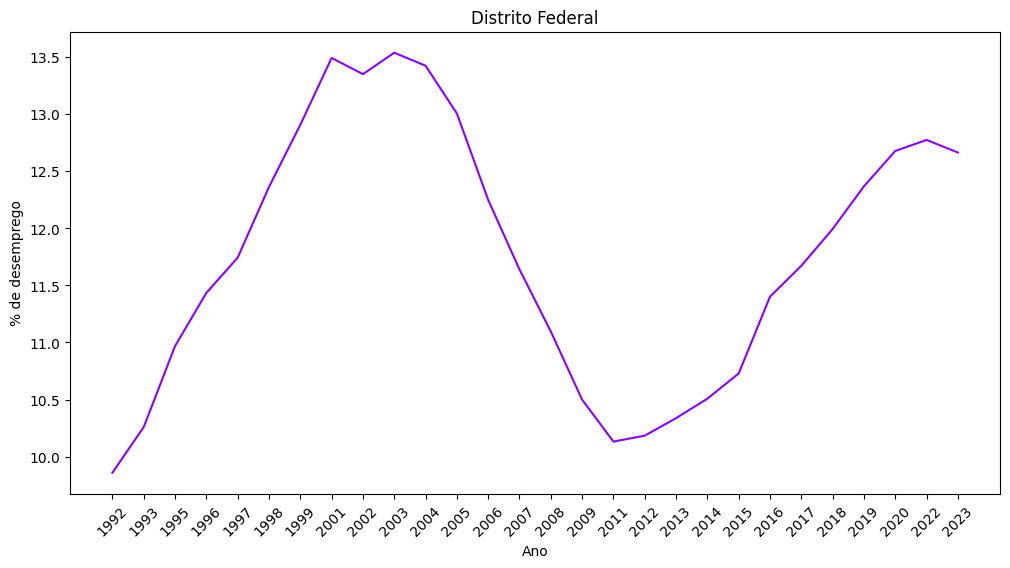

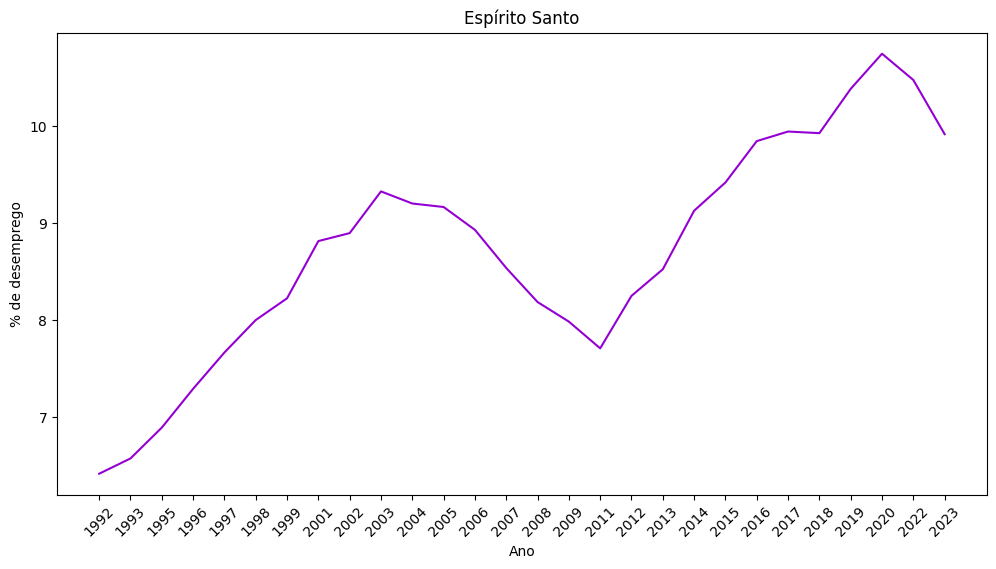

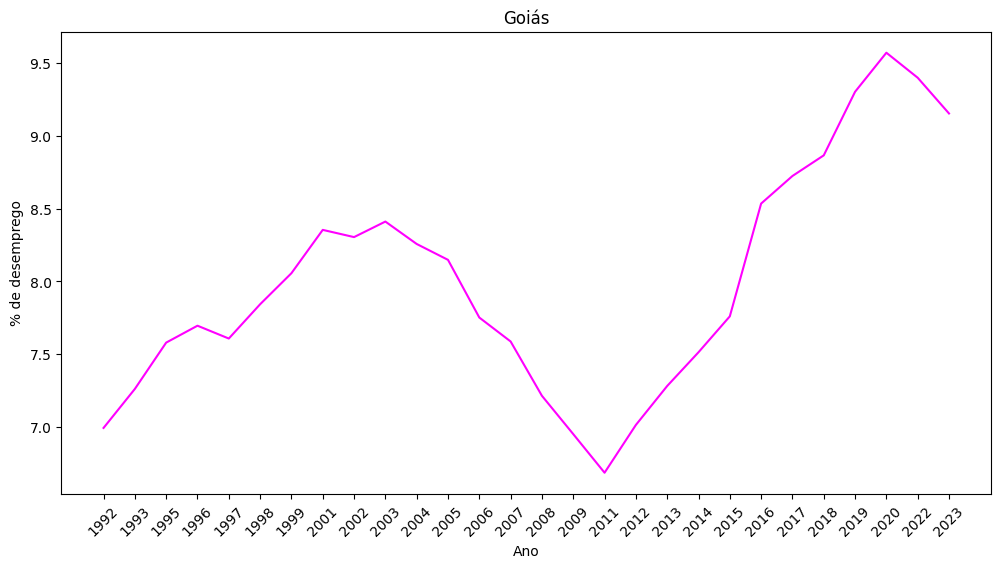

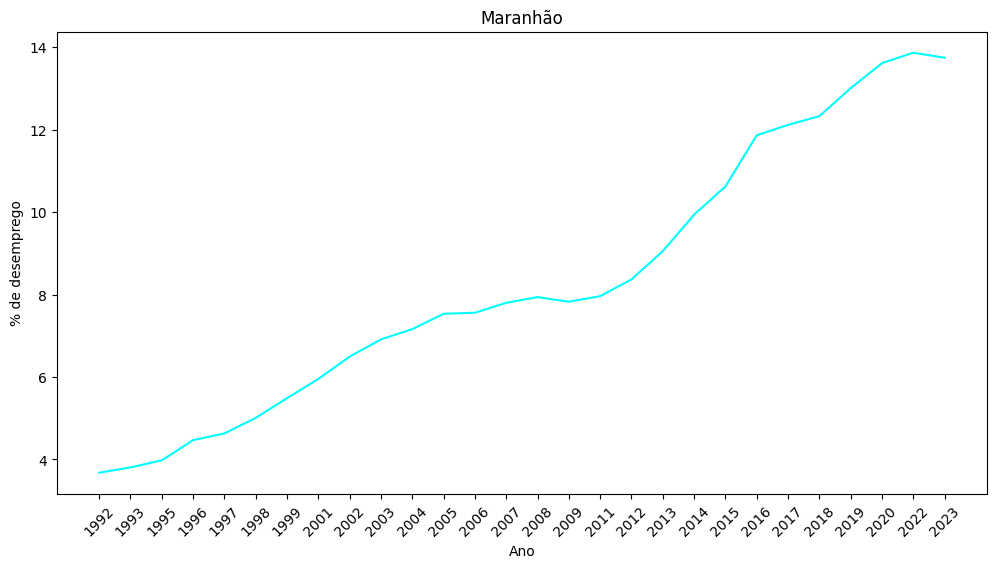

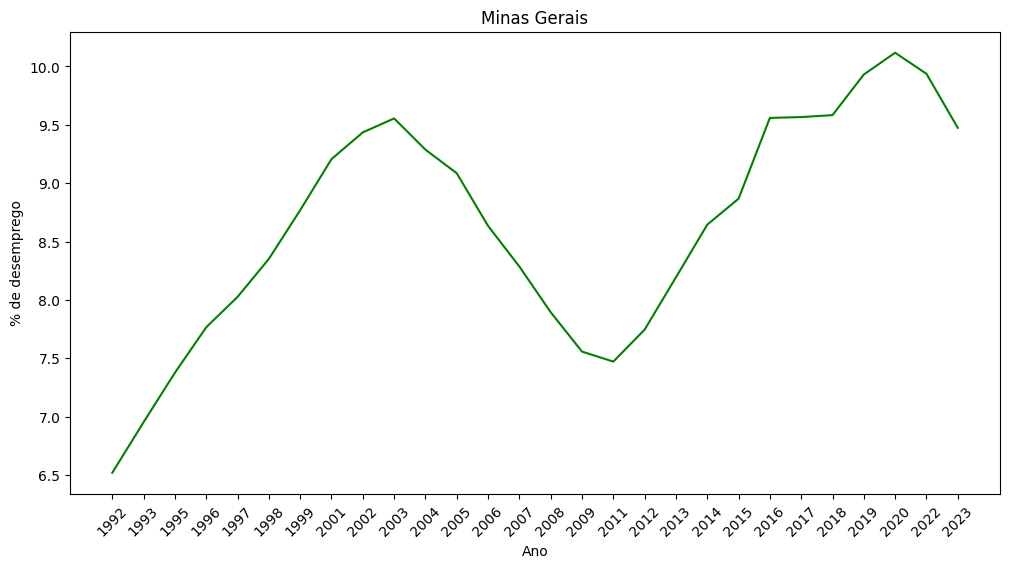

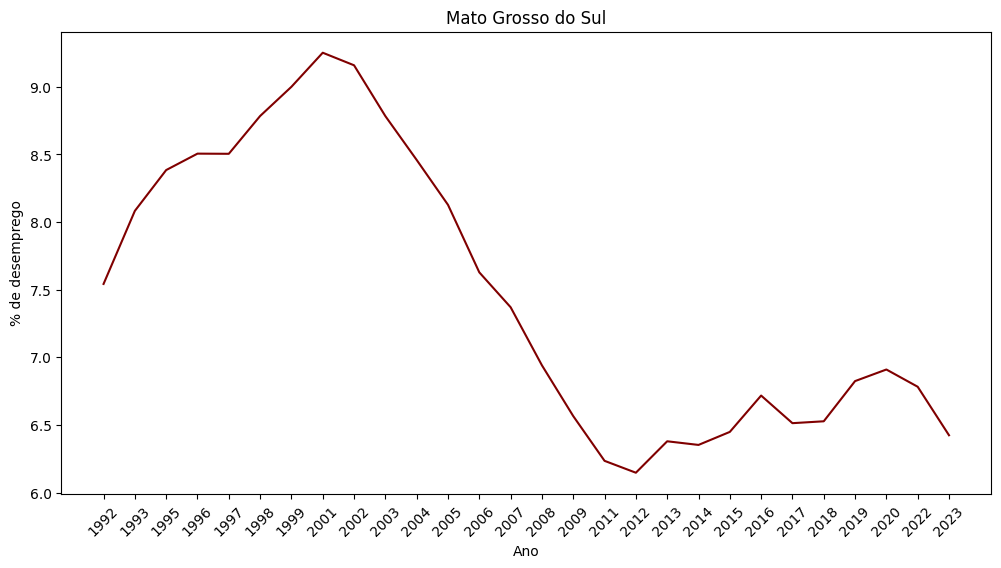

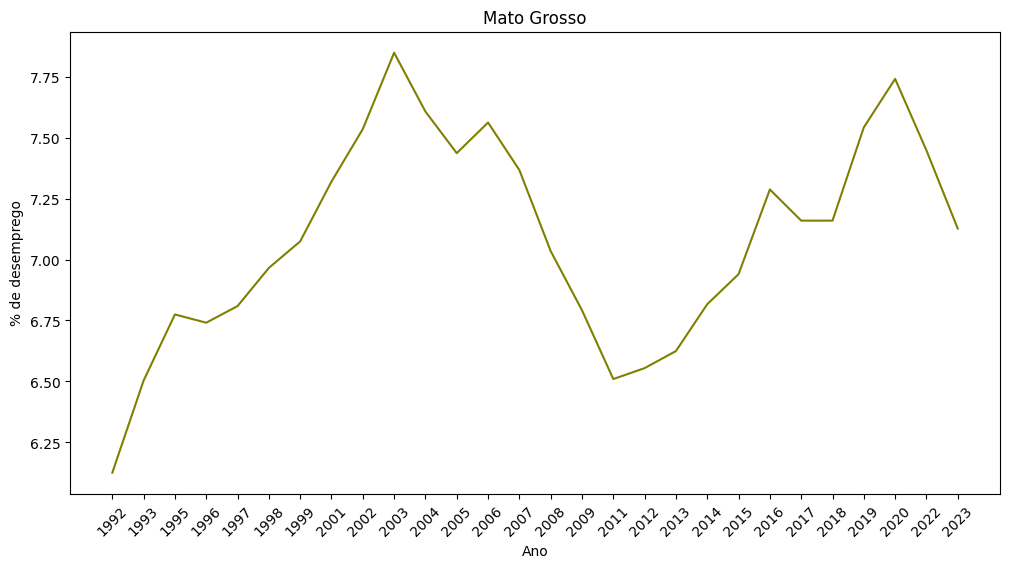

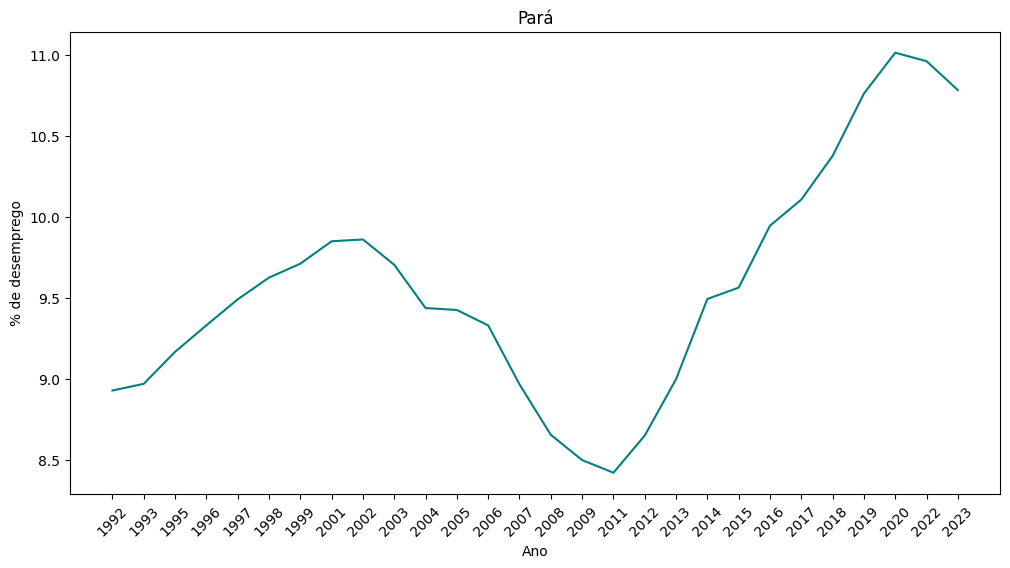

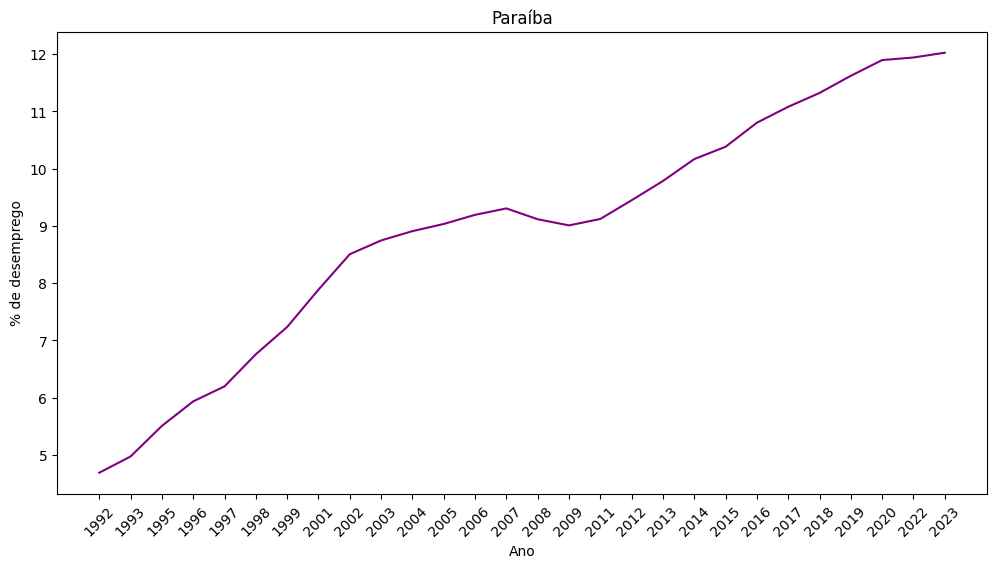

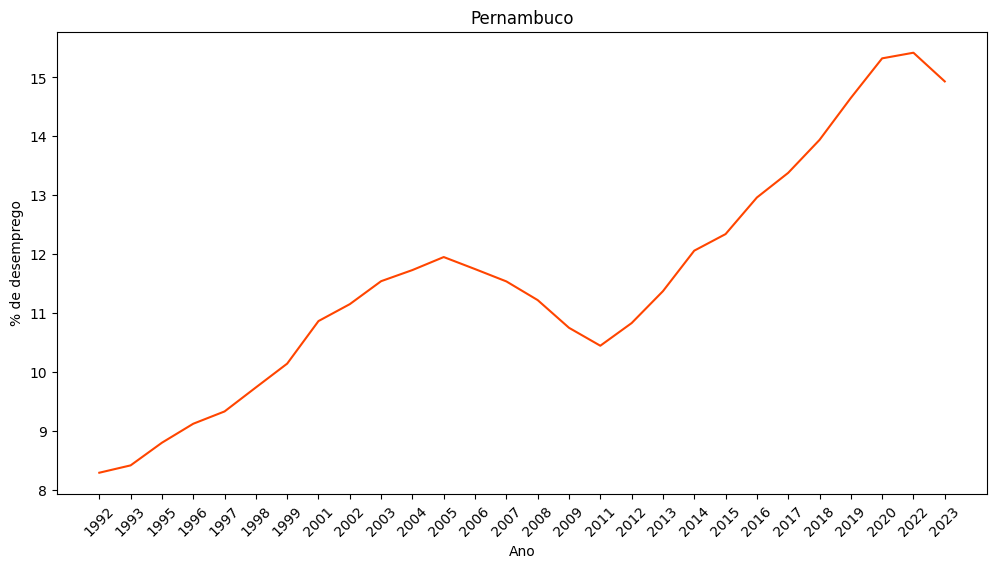

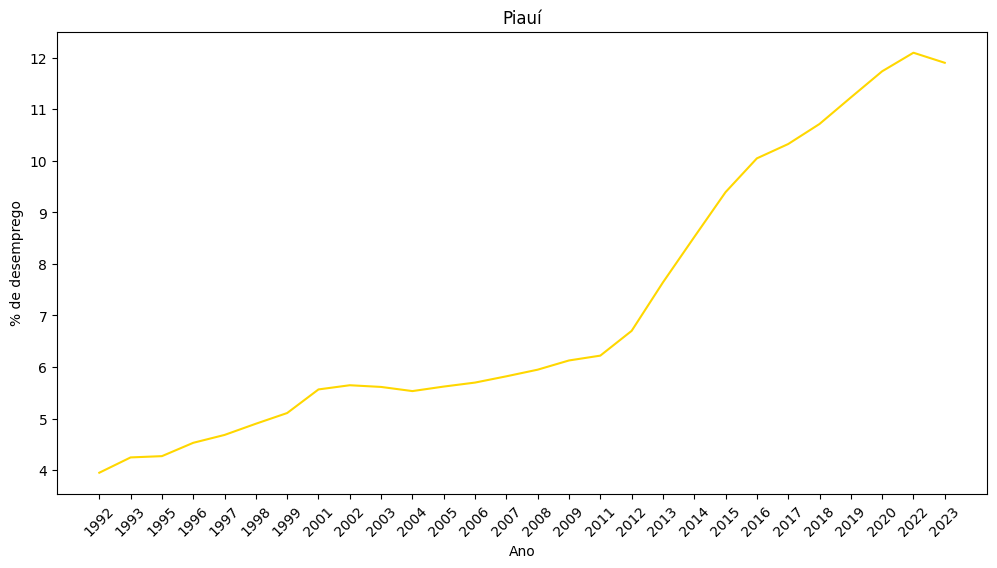

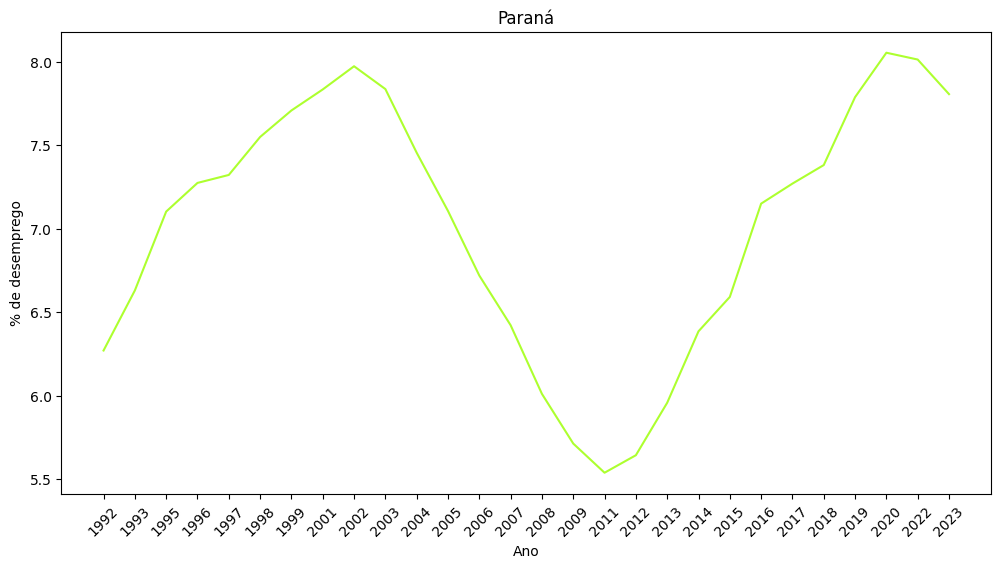

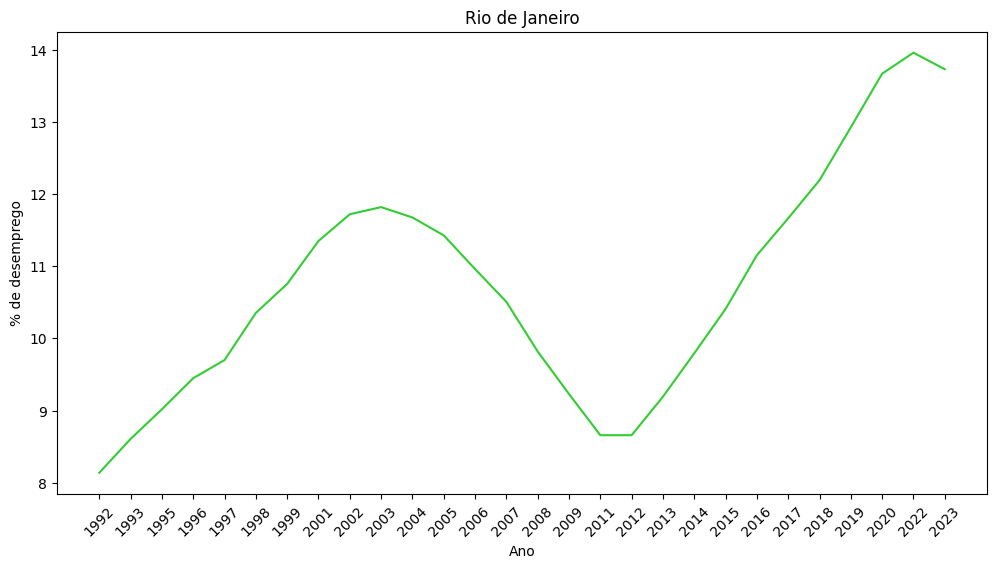

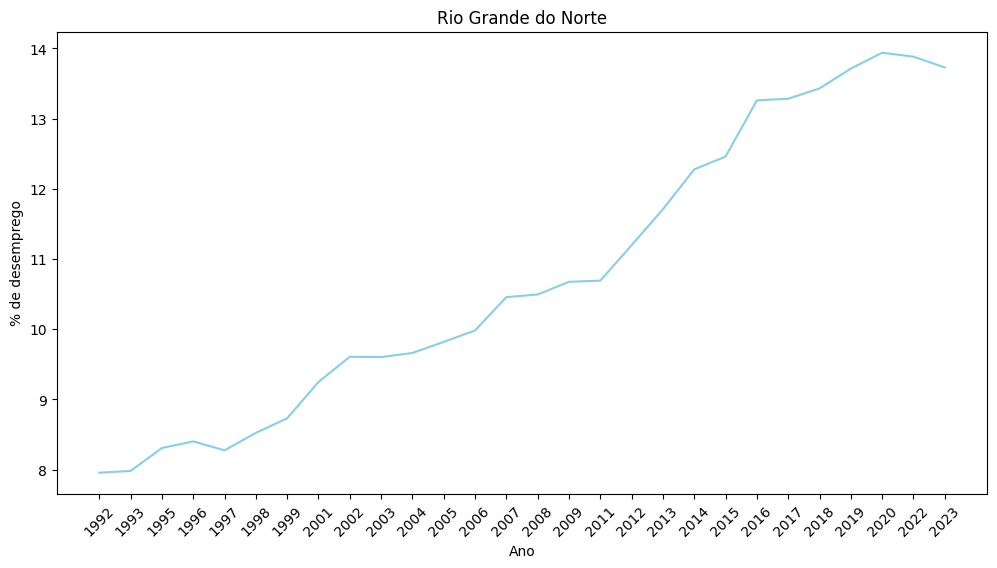

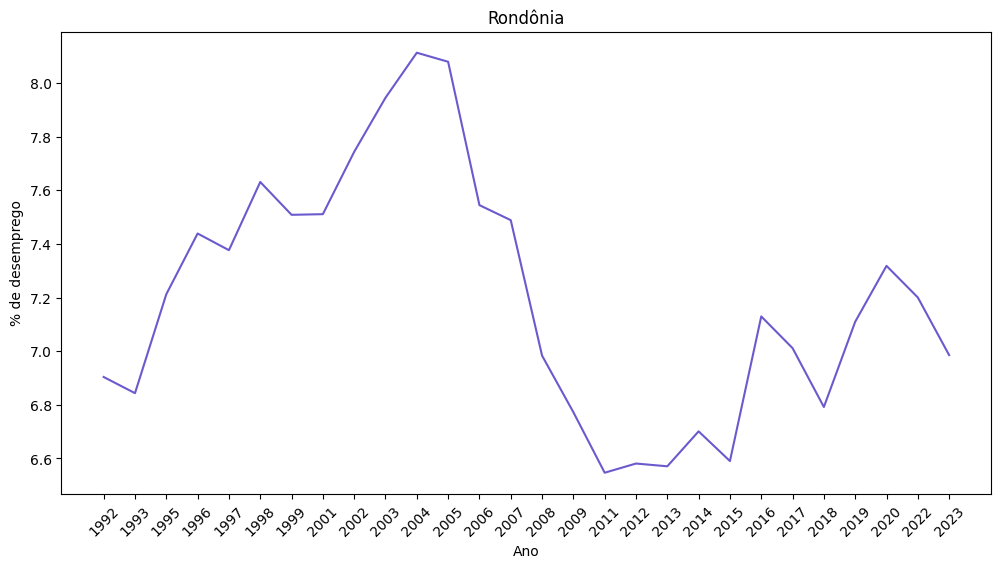

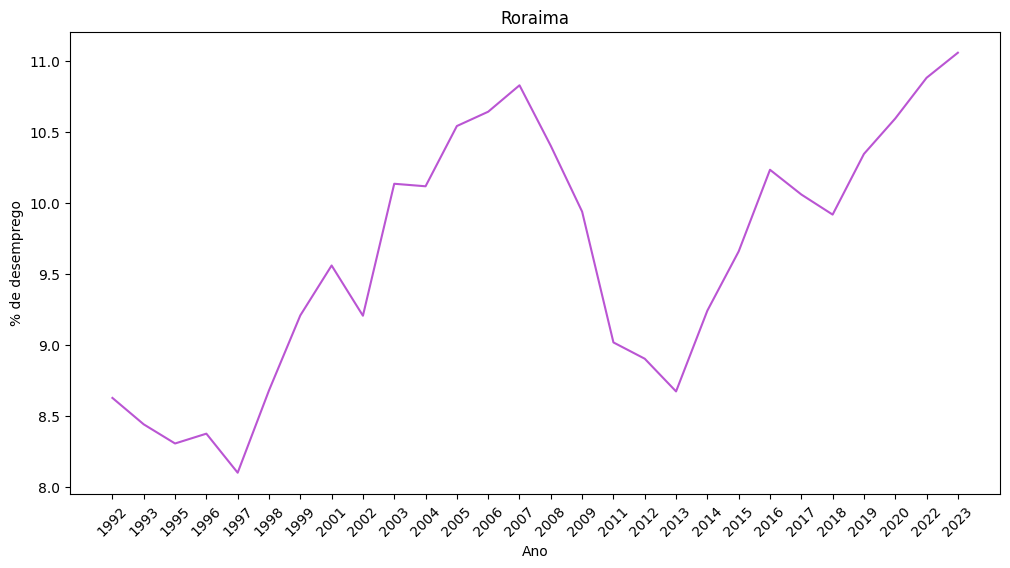

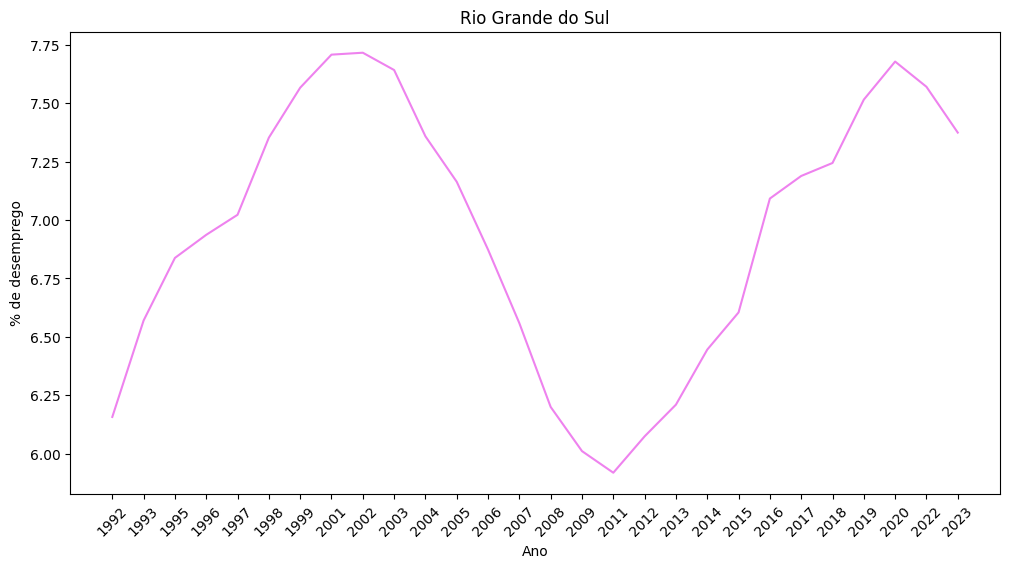

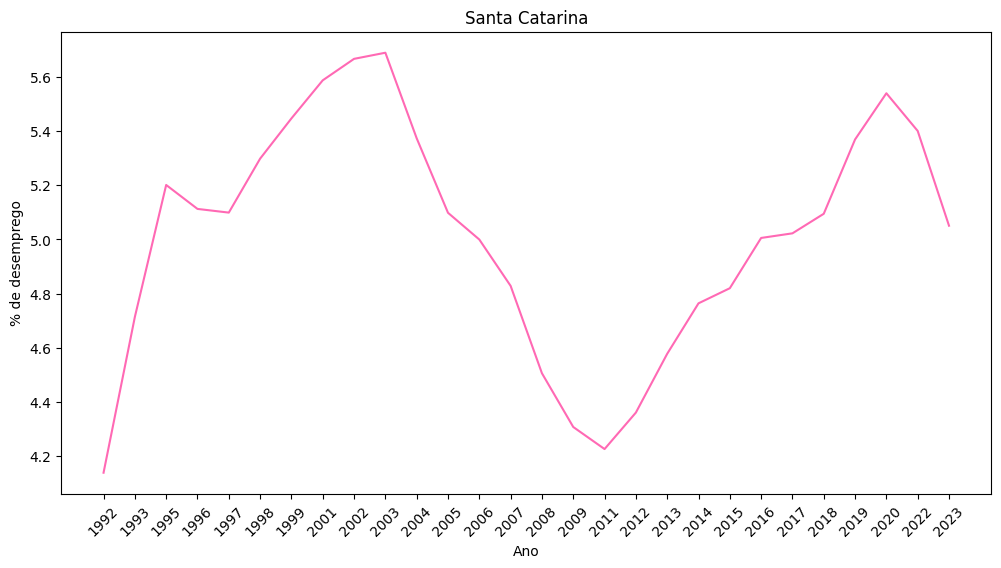

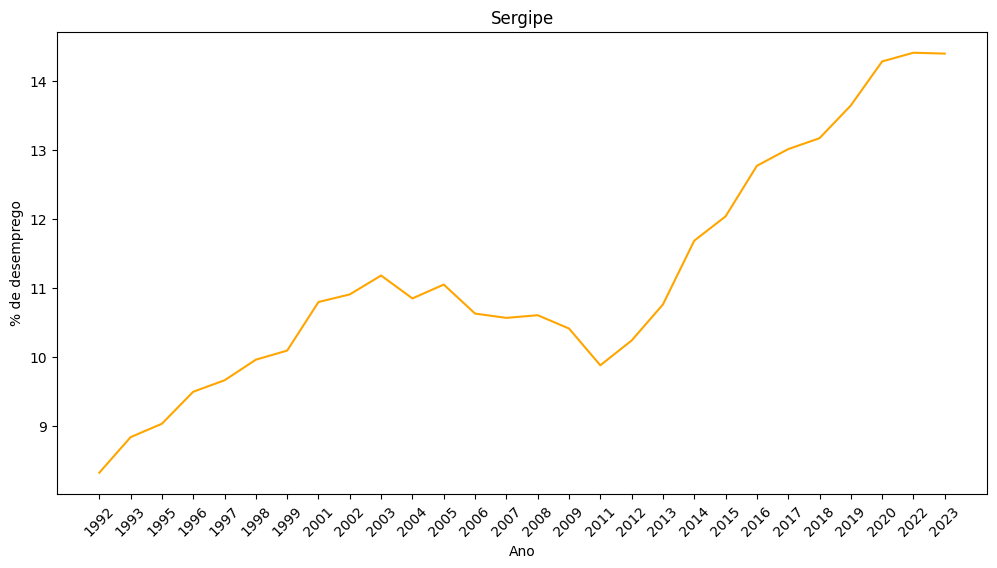

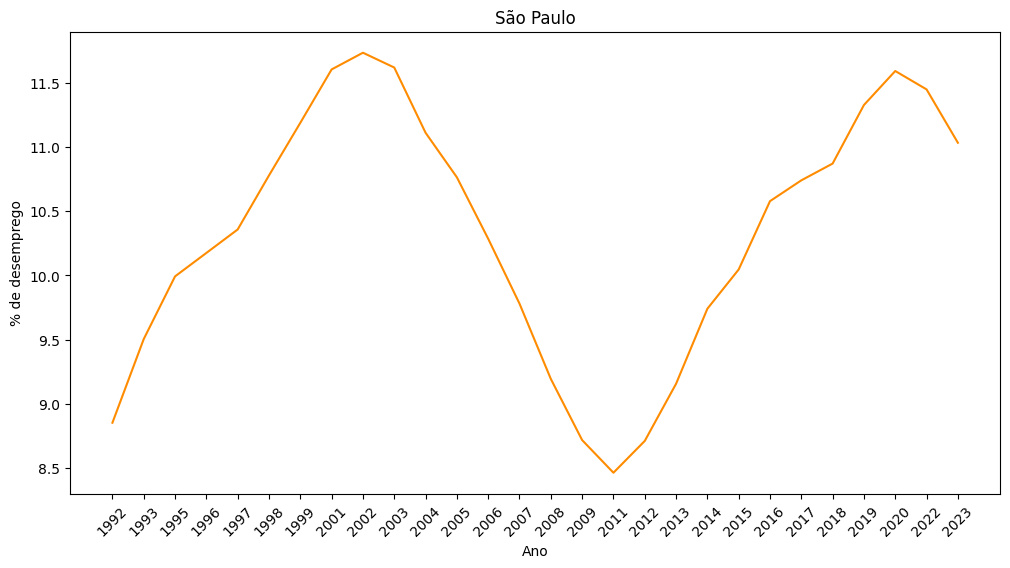

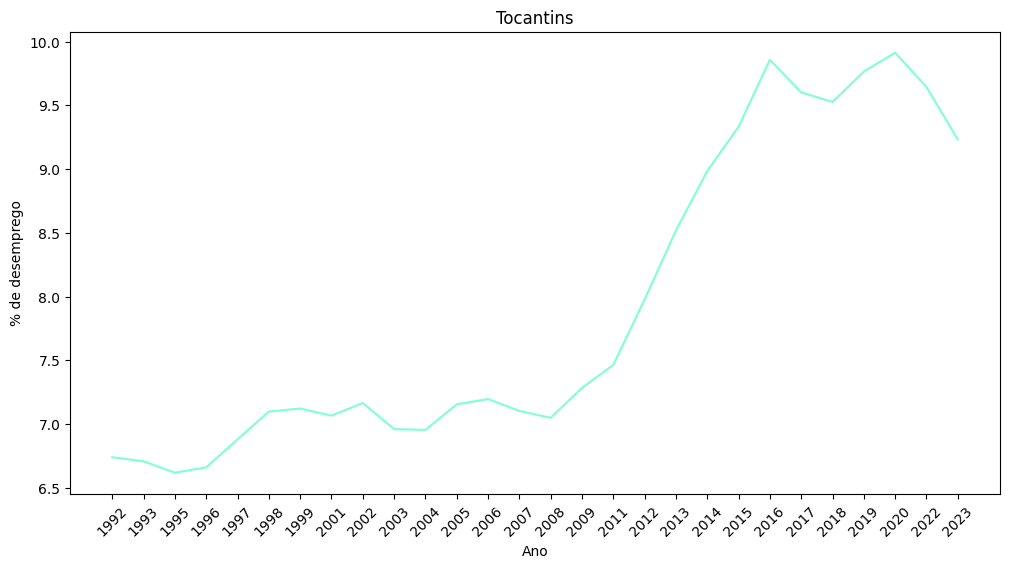

In [17]:
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF', '#9400D3', '#FF00FF',
          '#00FFFF', '#008000', '#800000', '#808000', '#008080', '#800080', '#FF4500', '#FFD700', '#ADFF2F',
          '#32CD32', '#87CEEB', '#6A5ACD', '#BA55D3', '#EE82EE', '#FF69B4', '#FFA500', '#FF8C00', '#7FFFD4',
          '#00CED1']

for i, column in enumerate(df_cma.columns):
    if i > 1:
        plot_column(df_cma[column], color=colors[i])